In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv('data/train_sample_1M.csv')
df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-07-16 10:02:58,2,3,66,189,10067,NaN,501,0,0,...,0,1,8267,1,0,1,2,50,675,10
1,2013-06-15 15:38:05,30,4,195,548,56440,NaN,1048,0,1,...,0,1,1385,1,1,1,0,185,185,58
2,2014-11-23 17:06:12,30,4,195,991,47725,NaN,1048,0,0,...,0,1,8803,1,0,1,3,151,69,6
3,2014-01-08 13:58:04,2,3,66,462,41898,2454.8588,1482,0,1,...,0,2,12009,1,0,1,2,50,680,95
4,2014-01-08 14:15:40,2,3,66,462,41898,2455.2272,1482,0,0,...,0,1,28494,6,0,4,2,50,680,77


# Basic Data review

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   date_time                  1000000 non-null  object 
 1   site_name                  1000000 non-null  int64  
 2   posa_continent             1000000 non-null  int64  
 3   user_location_country      1000000 non-null  int64  
 4   user_location_region       1000000 non-null  int64  
 5   user_location_city         1000000 non-null  int64  
 6   orig_destination_distance  641506 non-null   float64
 7   user_id                    1000000 non-null  int64  
 8   is_mobile                  1000000 non-null  int64  
 9   is_package                 1000000 non-null  int64  
 10  channel                    1000000 non-null  int64  
 11  srch_ci                    998731 non-null   object 
 12  srch_co                    998731 non-null   object 
 13  srch_adults_c

In [14]:
df.shape

(1000000, 24)

In [15]:
df.dtypes

date_time                     object
site_name                      int64
posa_continent                 int64
user_location_country          int64
user_location_region           int64
user_location_city             int64
orig_destination_distance    float64
user_id                        int64
is_mobile                      int64
is_package                     int64
channel                        int64
srch_ci                       object
srch_co                       object
srch_adults_cnt                int64
srch_children_cnt              int64
srch_rm_cnt                    int64
srch_destination_id            int64
srch_destination_type_id       int64
is_booking                     int64
cnt                            int64
hotel_continent                int64
hotel_country                  int64
hotel_market                   int64
hotel_cluster                  int64
dtype: object

In [16]:
df.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [17]:
df.isna().sum()

date_time                         0
site_name                         0
posa_continent                    0
user_location_country             0
user_location_region              0
user_location_city                0
orig_destination_distance    358494
user_id                           0
is_mobile                         0
is_package                        0
channel                           0
srch_ci                        1269
srch_co                        1269
srch_adults_cnt                   0
srch_children_cnt                 0
srch_rm_cnt                       0
srch_destination_id               0
srch_destination_type_id          0
is_booking                        0
cnt                               0
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
dtype: int64

In [18]:
df.duplicated().sum()

1

In [19]:
print(df["is_booking"].value_counts(normalize=True))

is_booking
0    0.92055
1    0.07945
Name: proportion, dtype: float64


In [21]:
# stay duration distribution (see visuals in data wrangler)
if "stay_duration" not in df.columns:
	df["srch_ci"] = pd.to_datetime(df["srch_ci"], errors="coerce")
	df["srch_co"] = pd.to_datetime(df["srch_co"], errors="coerce")
	df["stay_duration"] = (df["srch_co"] - df["srch_ci"]).dt.days

stay_counts = df["stay_duration"].value_counts().sort_index()
print(stay_counts)

stay_duration
-360.0    1
-322.0    1
-312.0    1
-293.0    1
-286.0    1
         ..
 261.0    1
 337.0    1
 368.0    1
 370.0    1
 516.0    1
Name: count, Length: 123, dtype: int64


In [23]:
# Duration time outliers
outliers = df[df["stay_duration"] > 30]
print("Count outlier stays > 30 Days:", len(outliers))

Count outlier stays > 30 Days: 492


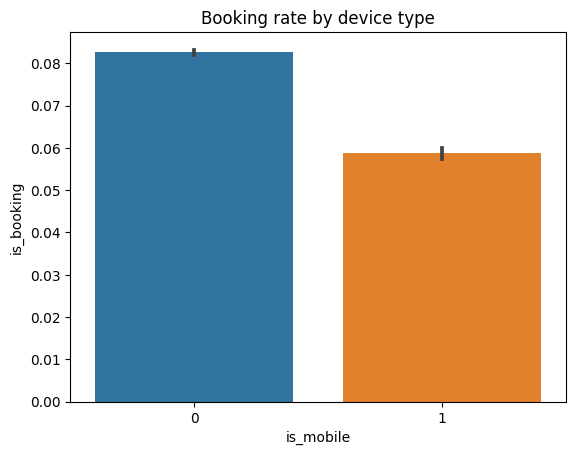

In [24]:
# Booking rate by device type
sns.barplot(data=df, x="is_mobile", y="is_booking")
plt.title("Booking rate by device type")
plt.show()

In [26]:
# Basic cleaning & type conversions
# Convert date columns to datetime (coerce errors to NaT)
date_cols = ["date_time", "srch_ci", "srch_co"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

In [27]:
# Cast clearly categorical integer-ids to pandas 'Int64' (nullable) to preserve NaNs
cat_int_cols = [
    "site_name","posa_continent","user_location_country",
    "user_location_region","user_location_city",
    "channel","srch_destination_id","srch_destination_type_id",
    "hotel_continent","hotel_country","hotel_market",
    "user_id","hotel_cluster"
]
for c in cat_int_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")


In [28]:
# Cast binary flags
for c in ["is_mobile","is_package","is_booking"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")


In [29]:
# Distances as float
if "orig_destination_distance" in df.columns:
    df["orig_destination_distance"] = pd.to_numeric(df["orig_destination_distance"], errors="coerce")

print("\nDtypes after:", df.dtypes)



Dtypes after: date_time                    datetime64[ns]
site_name                             Int64
posa_continent                        Int64
user_location_country                 Int64
user_location_region                  Int64
user_location_city                    Int64
orig_destination_distance           float64
user_id                               Int64
is_mobile                             Int64
is_package                            Int64
channel                               Int64
srch_ci                      datetime64[ns]
srch_co                      datetime64[ns]
srch_adults_cnt                       int64
srch_children_cnt                     int64
srch_rm_cnt                           int64
srch_destination_id                   Int64
srch_destination_type_id              Int64
is_booking                            Int64
cnt                                   int64
hotel_continent                       Int64
hotel_country                         Int64
hotel_market     

In [30]:
# Feature engineering
# Stay duration in days (can be negative/NaN if dates invalid; we’ll handle later)
df["stay_duration"] = (df["srch_co"] - df["srch_ci"]).dt.days

# Lead time: days between search time and check-in (how far in advance the search happened)
df["lead_time"] = (df["srch_ci"] - df["date_time"]).dt.days

# Search timestamp breakdown
df["search_year"] = df["date_time"].dt.year
df["search_month"] = df["date_time"].dt.month
df["search_dayofweek"] = df["date_time"].dt.dayofweek  # Mon=0, Sun=6
df["search_hour"] = df["date_time"].dt.hour

# Weekend stay flag (check-in day is Fri/Sat)
df["checkin_dayofweek"] = df["srch_ci"].dt.dayofweek
df["weekend_checkin"] = df["checkin_dayofweek"].isin([4,5]).astype("Int64")

# Season (rough, northern hemisphere)
def month_to_season(m):
    if pd.isna(m): return np.nan
    m = int(m)
    if m in [12,1,2]: return "winter"
    if m in [3,4,5]:  return "spring"
    if m in [6,7,8]:  return "summer"
    return "autumn"

df["search_season"] = df["search_month"].apply(month_to_season)


In [31]:
# Data quality
print("\n=== Missing values (top 30) ===")
na = df.isna().sum().sort_values(ascending=False)
print(na.head(30))

print("\n=== Duplicate rows ===")
print(df.duplicated().sum())

print("\n=== Unique counts (selected columns) ===")
sel_cols = [
    "site_name","posa_continent","user_location_country","user_location_region",
    "user_location_city","channel","srch_destination_id","srch_destination_type_id",
    "hotel_continent","hotel_country","hotel_market","user_id","hotel_cluster"
]
present_cols = [c for c in sel_cols if c in df.columns]
uniq = df[present_cols].nunique().sort_values(ascending=False)
print(uniq)


=== Missing values (top 30) ===
orig_destination_distance    358494
lead_time                      1269
stay_duration                  1269
checkin_dayofweek              1269
srch_co                        1269
srch_ci                        1269
hotel_continent                   0
hotel_country                     0
hotel_market                      0
hotel_cluster                     0
date_time                         0
is_booking                        0
search_year                       0
search_month                      0
search_dayofweek                  0
search_hour                       0
weekend_checkin                   0
cnt                               0
srch_destination_id               0
srch_destination_type_id          0
site_name                         0
srch_rm_cnt                       0
srch_children_cnt                 0
srch_adults_cnt                   0
channel                           0
is_package                        0
is_mobile                      

# Basic booking analysis

In [32]:
# Target & key distributions
def freq_table(series, top_n=20, sort_index=False):
    """Return a clean frequency table (value -> count, percent)."""
    vc = series.value_counts(dropna=False)
    if sort_index:
        vc = vc.sort_index()
    total = vc.sum()
    out = (
        pd.DataFrame({"count": vc, "percent": (vc / total * 100).round(2)})
        .reset_index().rename(columns={"index": series.name})
    )
    if top_n is not None:
        out = out.head(top_n)
    return out

print("\n=== is_booking distribution ===")
if "is_booking" in df.columns:
    print(freq_table(df["is_booking"], top_n=None, sort_index=True))



=== is_booking distribution ===
   is_booking   count  percent
0           0  920550    92.06
1           1   79450     7.94


In [33]:
print("\n=== hotel_cluster distribution (top 20) ===")
if "hotel_cluster" in df.columns:
    print(freq_table(df["hotel_cluster"], top_n=20))


=== hotel_cluster distribution (top 20) ===
    hotel_cluster  count  percent
0              91  27739     2.77
1              41  20286     2.03
2              48  19810     1.98
3              64  18819     1.88
4              65  17893     1.79
5               5  16396     1.64
6              98  15646     1.56
7              59  15159     1.52
8              18  14762     1.48
9              21  14547     1.45
10             42  14537     1.45
11             70  14461     1.45
12             46  14312     1.43
13             25  14284     1.43
14             83  13922     1.39
15             62  13870     1.39
16             28  13548     1.35
17             95  13491     1.35
18             82  13433     1.34
19             68  13256     1.33


In [34]:
print("\n=== stay_duration distribution (list + count, sorted by duration) ===")
# We keep negative/NaN visible to diagnose data quality
print(freq_table(df["stay_duration"], top_n=None, sort_index=True).head(60))


=== stay_duration distribution (list + count, sorted by duration) ===
    stay_duration   count  percent
0          -360.0       1     0.00
1          -322.0       1     0.00
2          -312.0       1     0.00
3          -293.0       1     0.00
4          -286.0       1     0.00
5          -263.0       2     0.00
6          -262.0       1     0.00
7          -261.0       1     0.00
8          -234.0       2     0.00
9          -230.0       1     0.00
10         -204.0       1     0.00
11         -200.0       1     0.00
12         -174.0       1     0.00
13         -142.0       1     0.00
14         -115.0       1     0.00
15         -109.0       1     0.00
16          -82.0       1     0.00
17          -58.0       1     0.00
18          -56.0       1     0.00
19          -55.0       1     0.00
20          -47.0       1     0.00
21          -29.0       1     0.00
22          -28.0       1     0.00
23          -27.0       1     0.00
24          -21.0       1     0.00
25            0.0  

In [35]:
print("\n=== lead_time distribution (list + count, sorted by days) ===")
print(freq_table(df["lead_time"], top_n=60, sort_index=True))


=== lead_time distribution (list + count, sorted by days) ===
    lead_time  count  percent
0      -349.0      1      0.0
1      -307.0      1      0.0
2      -294.0      1      0.0
3      -292.0      1      0.0
4      -275.0      1      0.0
5      -260.0      1      0.0
6      -240.0      1      0.0
7      -239.0      1      0.0
8      -224.0      1      0.0
9      -213.0      1      0.0
10     -207.0      1      0.0
11     -206.0      1      0.0
12     -204.0      2      0.0
13     -200.0      1      0.0
14     -196.0      1      0.0
15     -195.0      1      0.0
16     -194.0      1      0.0
17     -190.0      1      0.0
18     -186.0      1      0.0
19     -176.0      2      0.0
20     -172.0      1      0.0
21     -170.0      2      0.0
22     -156.0      1      0.0
23     -147.0      1      0.0
24     -144.0      1      0.0
25     -141.0      1      0.0
26     -138.0      1      0.0
27     -122.0      1      0.0
28     -114.0      1      0.0
29     -109.0      1      0.0
30     

In [37]:
# Booking rates by key categorical drivers
def rate_by(feature, min_count=2000, top_n=20, dropna=True):
    """
    Compute booking rate by a categorical feature.
    - min_count: filter out rare categories
    - top_n: show top N by total volume
    """
    if feature not in df.columns or "is_booking" not in df.columns:
        return pd.DataFrame()
    tmp = df[[feature, "is_booking"]].copy()
    if dropna:
        tmp = tmp.dropna(subset=[feature, "is_booking"])
    g = tmp.groupby(feature).agg(
        total=("is_booking","size"),
        bookings=("is_booking","sum")
    )
    g["booking_rate"] = (g["bookings"] / g["total"] * 100).round(2)
    g = g.sort_values("total", ascending=False)
    g = g[g["total"] >= min_count]
    if top_n is not None:
        g = g.head(top_n)
    return g.reset_index()

print("\n=== Booking rate by device (is_mobile) ===")
print(rate_by("is_mobile", min_count=0, top_n=None))

print("\n=== Booking rate by package (is_package) ===")
print(rate_by("is_package", min_count=0, top_n=None))

print("\n=== Booking rate by channel (top 20) ===")
print(rate_by("channel", min_count=5000, top_n=20))


=== Booking rate by device (is_mobile) ===
   is_mobile   total  bookings  booking_rate
0          0  865643     71564          8.27
1          1  134357      7886          5.87

=== Booking rate by package (is_package) ===
   is_package   total  bookings  booking_rate
0           0  751100     68744          9.15
1           1  248900     10706           4.3

=== Booking rate by channel (top 20) ===
   channel   total  bookings  booking_rate
0        9  554102     46626          8.41
1        0  124430      9160          7.36
2        1  101493      7039          6.94
3        2   78677      4789          6.09
4        5   61885      5728          9.26
5        3   44540      2525          5.67
6        4   21956      2922         13.31
7        7    8176       328          4.01


In [38]:
print("\n=== Booking rate by adults count ===")
print(rate_by("srch_adults_cnt", min_count=5000, top_n=None))

print("\n=== Booking rate by children count ===")
print(rate_by("srch_children_cnt", min_count=2000, top_n=None))

print("\n=== Booking rate by rooms count ===")
print(rate_by("srch_rm_cnt", min_count=2000, top_n=None))


=== Booking rate by adults count ===
   srch_adults_cnt   total  bookings  booking_rate
0                2  656357     44452          6.77
1                1  213505     26080         12.22
2                3   55051      3820          6.94
3                4   52943      3764          7.11
4                6    8938       515          5.76
5                5    7505       444          5.92

=== Booking rate by children count ===
   srch_children_cnt   total  bookings  booking_rate
0                  0  791222     64667          8.17
1                  1  111884      9260          8.28
2                  2   79271      4579          5.78
3                  3   12952       663          5.12
4                  4    3668       214          5.83

=== Booking rate by rooms count ===
   srch_rm_cnt   total  bookings  booking_rate
0            1  917097     71787          7.83
1            2   65960      6112          9.27
2            3   11102      1007          9.07
3            4    2763

In [39]:
print("\n=== Booking rate by hotel_country (top 20 by volume) ===")
print(rate_by("hotel_country", min_count=10000, top_n=20))


=== Booking rate by hotel_country (top 20 by volume) ===
    hotel_country   total  bookings  booking_rate
0              50  477717     43055          9.01
1               8   50859      2156          4.24
2             198   46787      5264         11.25
3             105   36148      2531           7.0
4              70   32145      2812          8.75
5             204   28475      1840          6.46
6              77   24495      1595          6.51
7             182   23530      1124          4.78
8             106   17204      1247          7.25
9             144   15769      1510          9.58
10            163   12789       364          2.85
11             63   11703       925           7.9


In [40]:
print("\n=== Booking rate by search_dayofweek (0=Mon..6=Sun) ===")
print(rate_by("search_dayofweek", min_count=0, top_n=None))


=== Booking rate by search_dayofweek (0=Mon..6=Sun) ===
   search_dayofweek   total  bookings  booking_rate
0                 2  161754     13001          8.04
1                 0  161699     13099           8.1
2                 1  160922     12927          8.03
3                 3  142449     11773          8.26
4                 6  132563      9459          7.14
5                 4  129247     10975          8.49
6                 5  111366      8216          7.38


In [41]:
print("\n=== Booking rate by search_hour (0..23) ===")
print(rate_by("search_hour", min_count=0, top_n=None))


=== Booking rate by search_hour (0..23) ===
    search_hour  total  bookings  booking_rate
0            11  60168      5207          8.65
1            12  59778      5069          8.48
2            18  59607      4377          7.34
3            19  59159      4232          7.15
4            13  58297      4880          8.37
5            17  58239      4414          7.58
6            14  57420      4870          8.48
7            10  57236      4988          8.71
8            16  56772      4533          7.98
9            15  55703      4663          8.37
10           20  55083      3941          7.15
11            9  51477      4550          8.84
12           21  48970      3352          6.85
13            8  44915      3874          8.63
14           22  40088      2685           6.7
15            7  37183      3200          8.61
16           23  30002      2076          6.92
17            6  27213      2280          8.38
18            0  20584      1426          6.93
19            5

In [42]:
print("\n=== Booking rate by season (search_season) ===")
print(rate_by("search_season", min_count=0, top_n=None))

print("\n=== Booking rate by weekend_checkin ===")
print(rate_by("weekend_checkin", min_count=0, top_n=None))


=== Booking rate by season (search_season) ===
  search_season   total  bookings  booking_rate
0        autumn  288044     22342          7.76
1        summer  287566     21884          7.61
2        spring  220839     18538          8.39
3        winter  203551     16686           8.2

=== Booking rate by weekend_checkin ===
   weekend_checkin   total  bookings  booking_rate
0                0  636381     52584          8.26
1                1  363619     26866          7.39


In [44]:
import os
import math

# Config
SEED = 42
SAVE_FIGS = True
OUT_DIR = "figs"
SAMPLE_PER_CLASS_DISTS = 40000  # stratified sample for dense hist/KDE plots
PALETTE = "Set2"

# Create output dir if saving
if SAVE_FIGS:
    os.makedirs(OUT_DIR, exist_ok=True)

# Pretty plots
sns.set_theme(style="whitegrid", context="talk", palette=PALETTE)

In [ ]:
# Parse dates
for c in ["date_time", "srch_ci", "srch_co"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Core asserts
needed_cols = ["is_booking", "date_time", "srch_ci", "srch_co",
               "srch_adults_cnt", "srch_children_cnt", "srch_rm_cnt"]
missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Distance numeric
if "orig_destination_distance" in df.columns:
    df["orig_destination_distance"] = pd.to_numeric(df["orig_destination_distance"], errors="coerce")

In [46]:
# Feature engineering
# -------------------
# Normalize dates to midnight to avoid time-of-day artifacts in day diffs
dt_norm = df["date_time"].dt.normalize()
ci_norm = df["srch_ci"].dt.normalize()
co_norm = df["srch_co"].dt.normalize()

df["lead_time"] = (ci_norm - dt_norm).dt.days               # days between search and check-in
df["stay_duration"] = (co_norm - ci_norm).dt.days           # nights between check-in/out
df["search_hour"] = df["date_time"].dt.hour
df["search_dayofweek"] = df["date_time"].dt.dayofweek       # 0=Mon .. 6=Sun

# Clean ranges for EDA readability
df["lead_time_clipped"] = df["lead_time"].clip(lower=0, upper=540)  # up to ~18 months
df["stay_duration_clean"] = df["stay_duration"].where(df["stay_duration"].between(1, 45), np.nan)

# Distance transforms (skew-taming): clip extreme tails + log1p column
if "orig_destination_distance" in df.columns:
    q01, q99 = df["orig_destination_distance"].quantile([0.01, 0.99])
    df["distance_clipped"] = df["orig_destination_distance"].clip(q01, q99)
    df["distance_log1p"] = np.log1p(df["distance_clipped"])

# Weekday label (nice axis)
WEEKDAY = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
df["weekday_label"] = df["search_dayofweek"].map(WEEKDAY)


In [48]:
# Helper functions
# -------------------
def booking_rate_table(frame: pd.DataFrame, feature: str, min_count: int = 0,
                       dropna: bool = True, top_n: int | None = None,
                       sort_by: str = "total") -> pd.DataFrame:
    """
    Aggregate booking counts and booking rate by a categorical/numeric feature.
    """
    tmp = frame[[feature, "is_booking"]].copy()
    if dropna:
        tmp = tmp.dropna(subset=[feature, "is_booking"])
    g = tmp.groupby(feature, dropna=False).agg(
        total=("is_booking", "size"),
        bookings=("is_booking", "sum")
    ).reset_index()
    g["booking_rate_pct"] = (g["bookings"] / g["total"] * 100).round(2)
    # Filter by volume
    if min_count > 0:
        g = g[g["total"] >= min_count]
    # Sorting
    if sort_by == "feature":
        g = g.sort_values(feature)
    elif sort_by == "rate":
        g = g.sort_values("booking_rate_pct", ascending=False)
    else:
        g = g.sort_values("total", ascending=False)
    # Top-N
    if top_n is not None:
        g = g.head(top_n)
    return g

def stratified_sample_by_target(frame: pd.DataFrame, target_col="is_booking",
                                per_class=40000, random_state=SEED, cols=None) -> pd.DataFrame:
    """
    Stratified down-sample to balance booking vs non-booking for dense plots.
    """
    if cols is None:
        cols = frame.columns.tolist()
    parts = []
    for val, grp in frame.groupby(target_col):
        n = min(per_class, len(grp))
        parts.append(grp[cols].sample(n=n, random_state=random_state))
    return pd.concat(parts, axis=0).sample(frac=1.0, random_state=random_state)

def savefig(fig, name: str):
    if SAVE_FIGS:
        fig.savefig(os.path.join(OUT_DIR, name), dpi=160, bbox_inches="tight")


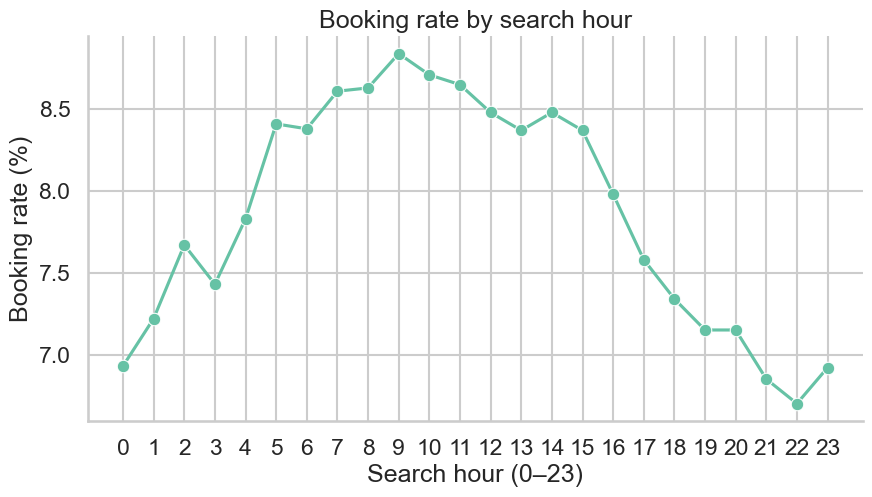

In [49]:
# 1) Booking rate by search hour (line/points)
# -------------------
hour_tbl = booking_rate_table(df, "search_hour", min_count=0, sort_by="feature")
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=hour_tbl, x="search_hour", y="booking_rate_pct", marker="o", ax=ax)
ax.set_title("Booking rate by search hour")
ax.set_xlabel("Search hour (0–23)")
ax.set_ylabel("Booking rate (%)")
ax.set_xticks(range(0, 24, 1))
sns.despine()
savefig(fig, "booking_rate_by_hour.png")
plt.show()

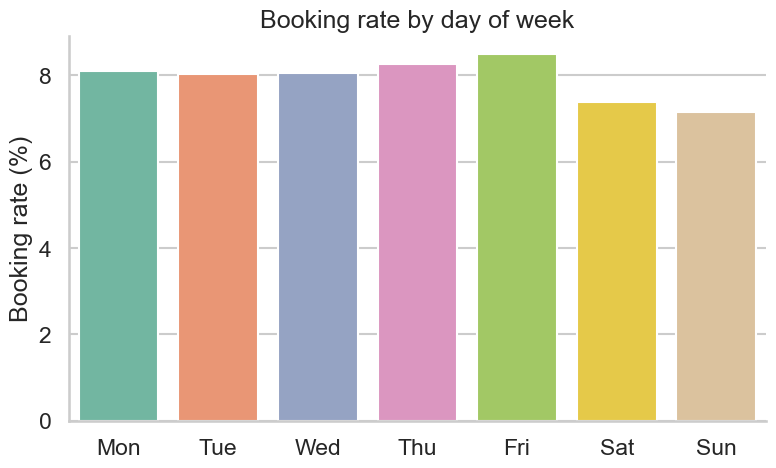

In [50]:
# 2) Booking rate by day of week
# -------------------
dow_tbl = booking_rate_table(df, "weekday_label", min_count=0, sort_by="feature")
# Ensure weekday order
dow_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
dow_tbl["weekday_label"] = pd.Categorical(dow_tbl["weekday_label"], categories=dow_order, ordered=True)
dow_tbl = dow_tbl.sort_values("weekday_label")
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=dow_tbl, x="weekday_label", y="booking_rate_pct", ax=ax)
ax.set_title("Booking rate by day of week")
ax.set_xlabel("")
ax.set_ylabel("Booking rate (%)")
sns.despine()
savefig(fig, "booking_rate_by_weekday.png")
plt.show()

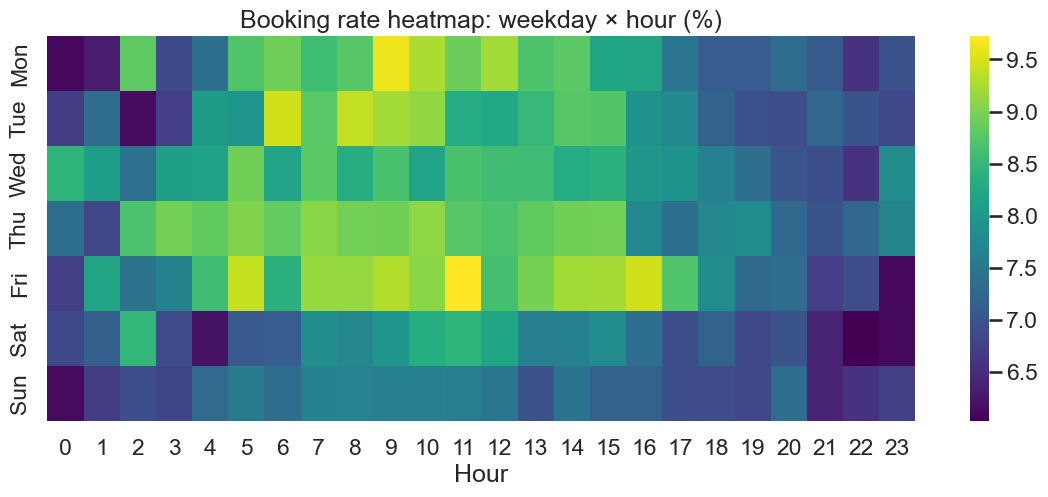

In [ ]:
# 3) Heatmap: booking rate by hour x weekday (nice for patterns)
# -------------------
tmp = df.dropna(subset=["search_hour", "search_dayofweek", "is_booking"])
pivot = tmp.pivot_table(index="weekday_label", columns="search_hour",
                        values="is_booking", aggfunc="mean") * 100.0
# Reindex rows to Mon..Sun
pivot = pivot.reindex(dow_order)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(pivot, annot=False, cmap="viridis", ax=ax)
ax.set_title("Booking rate heatmap: weekday × hour (%)")
ax.set_xlabel("Hour")
ax.set_ylabel("")
savefig(fig, "booking_rate_heatmap_weekday_hour.png")
plt.show()

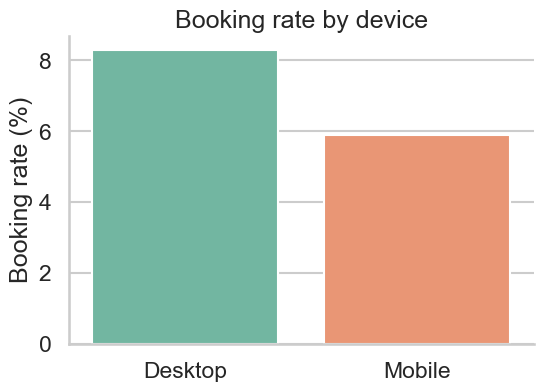

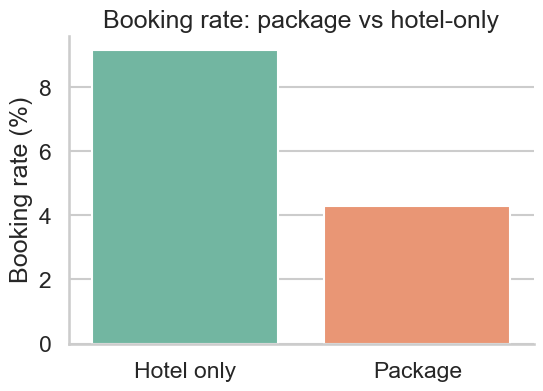

In [ ]:
# 4) Booking rate by device & package
# -------------------
if "is_mobile" in df.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    mob_tbl = booking_rate_table(df, "is_mobile", min_count=0, sort_by="feature")
    mob_tbl["device"] = mob_tbl["is_mobile"].map({0:"Desktop", 1:"Mobile"})
    sns.barplot(data=mob_tbl, x="device", y="booking_rate_pct", ax=ax)
    ax.set_title("Booking rate by device")
    ax.set_xlabel("")
    ax.set_ylabel("Booking rate (%)")
    sns.despine()
    savefig(fig, "booking_rate_by_device.png")
    plt.show()

if "is_package" in df.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    pkg_tbl = booking_rate_table(df, "is_package", min_count=0, sort_by="feature")
    pkg_tbl["package"] = pkg_tbl["is_package"].map({0:"Hotel only", 1:"Package"})
    sns.barplot(data=pkg_tbl, x="package", y="booking_rate_pct", ax=ax)
    ax.set_title("Booking rate: package vs hotel-only")
    ax.set_xlabel("")
    ax.set_ylabel("Booking rate (%)")
    sns.despine()
    savefig(fig, "booking_rate_by_package.png")
    plt.show()

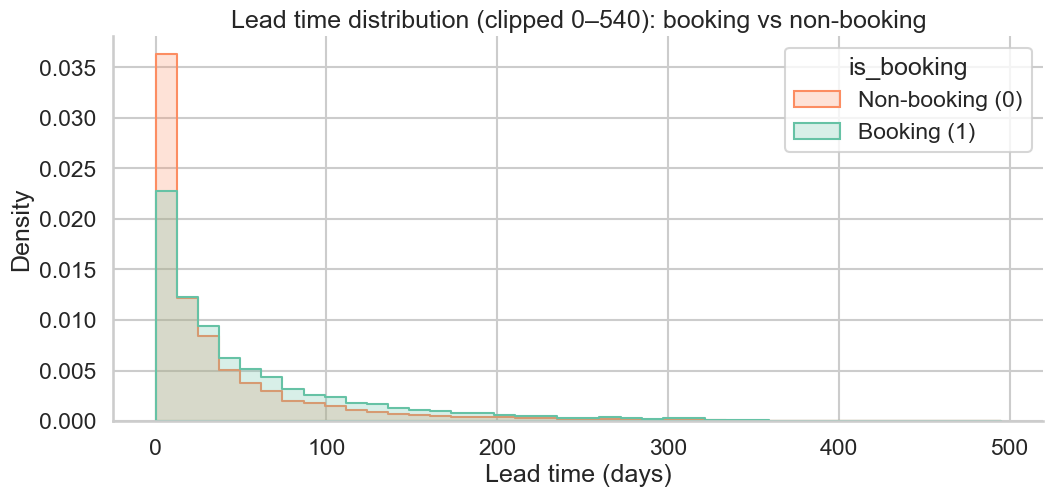

In [ ]:
# 5) Lead time distribution: booking vs non (stratified sample)
# -------------------
lead_df = df[["lead_time_clipped", "is_booking"]].dropna()
lead_sample = stratified_sample_by_target(lead_df, per_class=SAMPLE_PER_CLASS_DISTS,
                                          cols=["lead_time_clipped","is_booking"])
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=lead_sample, x="lead_time_clipped", hue="is_booking", element="step",
             stat="density", common_norm=False, bins=40, ax=ax)
ax.set_title("Lead time distribution (clipped 0–540): booking vs non-booking")
ax.set_xlabel("Lead time (days)")
ax.set_ylabel("Density")
ax.legend(title="is_booking", labels=["Non-booking (0)", "Booking (1)"])
sns.despine()
savefig(fig, "dist_lead_time_booking_vs_non.png")
plt.show()

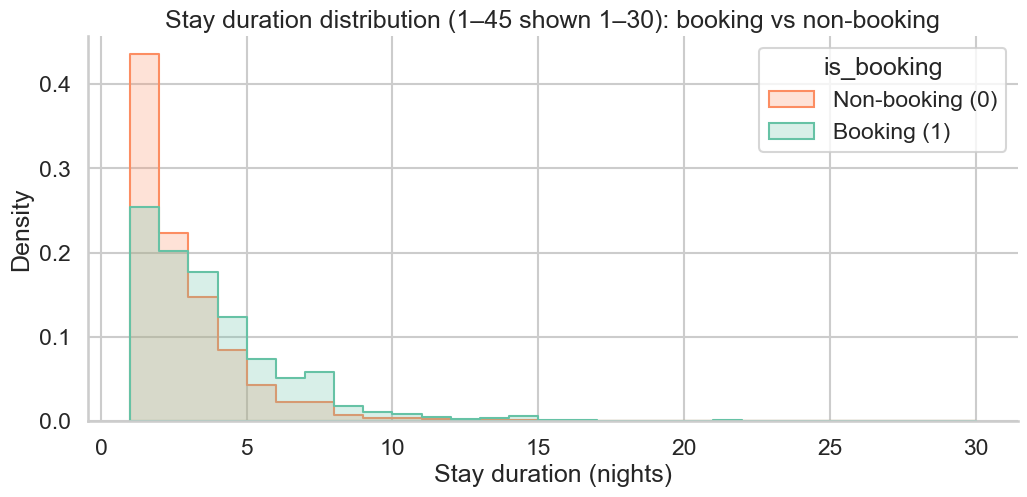

In [ ]:
# 6) Stay duration distribution: booking vs non (stratified sample)
# -------------------
stay_df = df[["stay_duration_clean", "is_booking"]].dropna()
stay_sample = stratified_sample_by_target(stay_df, per_class=SAMPLE_PER_CLASS_DISTS,
                                          cols=["stay_duration_clean","is_booking"])
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=stay_sample, x="stay_duration_clean", hue="is_booking", element="step",
             stat="density", common_norm=False, bins=np.arange(1, 31, 1), ax=ax)
ax.set_title("Stay duration distribution (1–45 shown 1–30): booking vs non-booking")
ax.set_xlabel("Stay duration (nights)")
ax.set_ylabel("Density")
ax.legend(title="is_booking", labels=["Non-booking (0)", "Booking (1)"])
sns.despine()
savefig(fig, "dist_stay_duration_booking_vs_non.png")
plt.show()

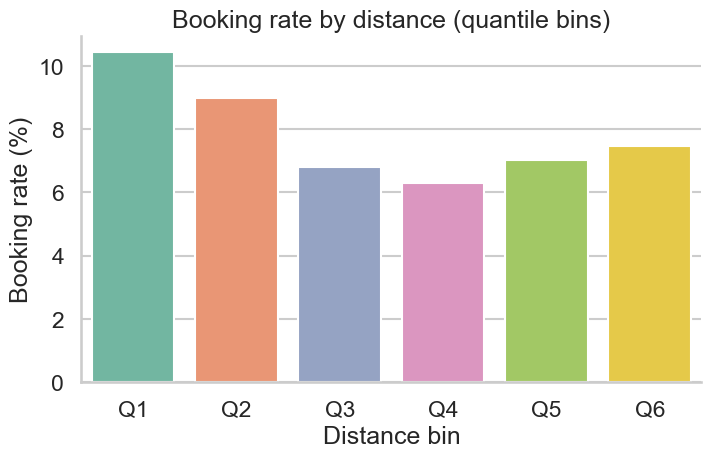

In [ ]:
# 7) Booking rate by distance (quantile bins)
# -------------------
if "orig_destination_distance" in df.columns:
    dist = df["orig_destination_distance"].dropna()
    if len(dist) > 0:
        # Build quantile bins (robust to skew)
        qs = dist.quantile([0.0, 0.25, 0.5, 0.75, 0.9, 0.99, 1.0]).values
        edges = np.unique(qs)
        if len(edges) < 4:
            edges = np.quantile(dist, [0.0, 0.5, 0.9, 1.0])
            edges = np.unique(edges)
        labels = [f"Q{i+1}" for i in range(len(edges)-1)]
        df["_dist_bin"] = pd.cut(df["orig_destination_distance"], bins=edges,
                                 labels=labels, include_lowest=True, ordered=True)

        dist_tbl = booking_rate_table(df, "_dist_bin", min_count=2000, sort_by="feature")
        fig, ax = plt.subplots(figsize=(8, 4.5))
        sns.barplot(data=dist_tbl, x="_dist_bin", y="booking_rate_pct", ax=ax)
        ax.set_title("Booking rate by distance (quantile bins)")
        ax.set_xlabel("Distance bin")
        ax.set_ylabel("Booking rate (%)")
        sns.despine()
        savefig(fig, "booking_rate_by_distance_bins.png")
        plt.show()

        df.drop(columns=["_dist_bin"], inplace=True, errors="ignore")

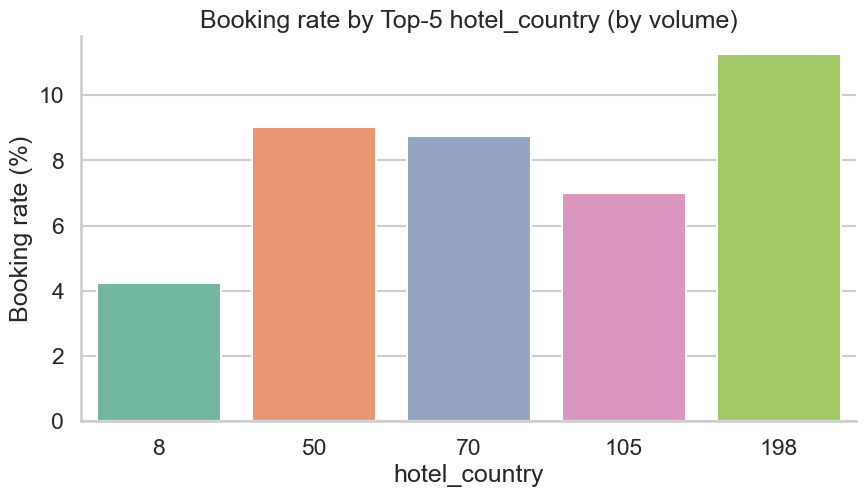

In [ ]:
# 8) Booking rate: Top-5 hotel_country
# -------------------
if "hotel_country" in df.columns:
    # Top-5 by total volume
    vol = df["hotel_country"].value_counts().head(5).index.tolist()
    top_c = df[df["hotel_country"].isin(vol)].copy()
    c_tbl = booking_rate_table(top_c, "hotel_country", min_count=0, top_n=None, sort_by="total")
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(data=c_tbl, x="hotel_country", y="booking_rate_pct", ax=ax)
    ax.set_title("Booking rate by Top-5 hotel_country (by volume)")
    ax.set_xlabel("hotel_country")
    ax.set_ylabel("Booking rate (%)")
    sns.despine()
    savefig(fig, "booking_rate_top5_hotel_country.png")
    plt.show()

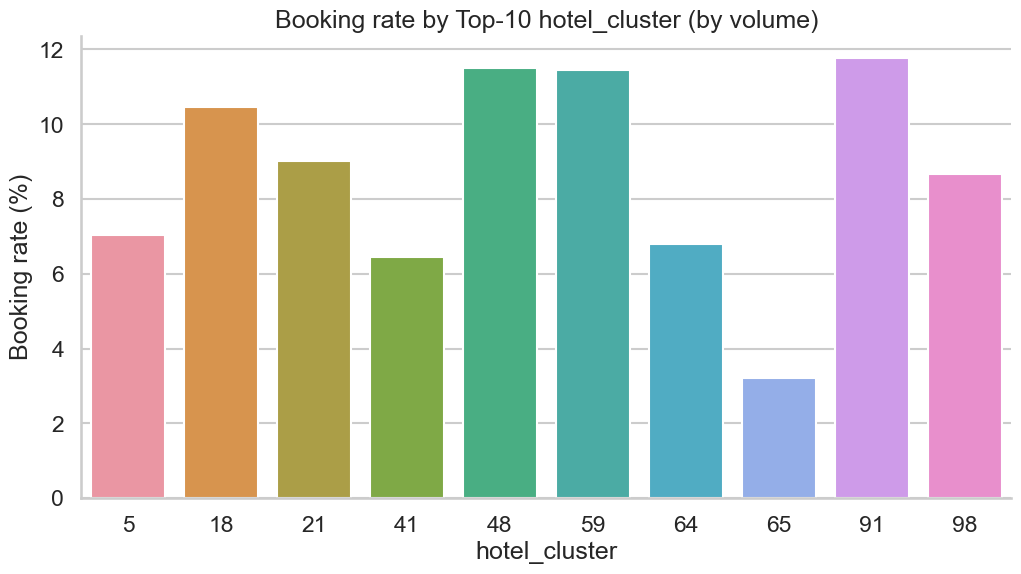

In [ ]:
# 9) Booking rate: Top-10 hotel_cluster
# -------------------
if "hotel_cluster" in df.columns:
    top_clusters = df["hotel_cluster"].value_counts().head(10).index.tolist()
    top_cl = df[df["hotel_cluster"].isin(top_clusters)].copy()
    cl_tbl = booking_rate_table(top_cl, "hotel_cluster", min_count=0, top_n=None, sort_by="total")
    # Order bars by booking rate descending for readability
    cl_tbl = cl_tbl.sort_values("booking_rate_pct", ascending=False)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=cl_tbl, x="hotel_cluster", y="booking_rate_pct", ax=ax)
    ax.set_title("Booking rate by Top-10 hotel_cluster (by volume)")
    ax.set_xlabel("hotel_cluster")
    ax.set_ylabel("Booking rate (%)")
    sns.despine()
    savefig(fig, "booking_rate_top10_hotel_cluster.png")
    plt.show()

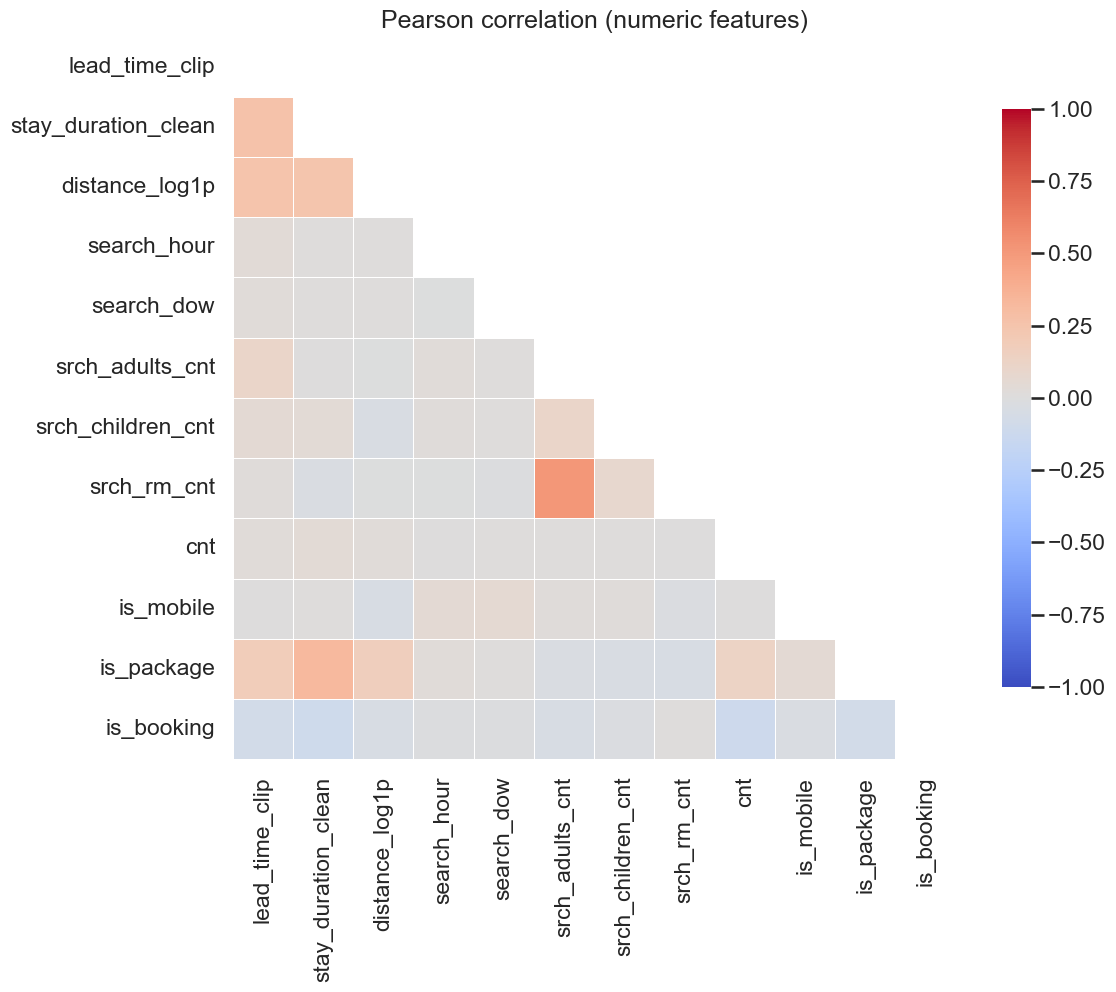

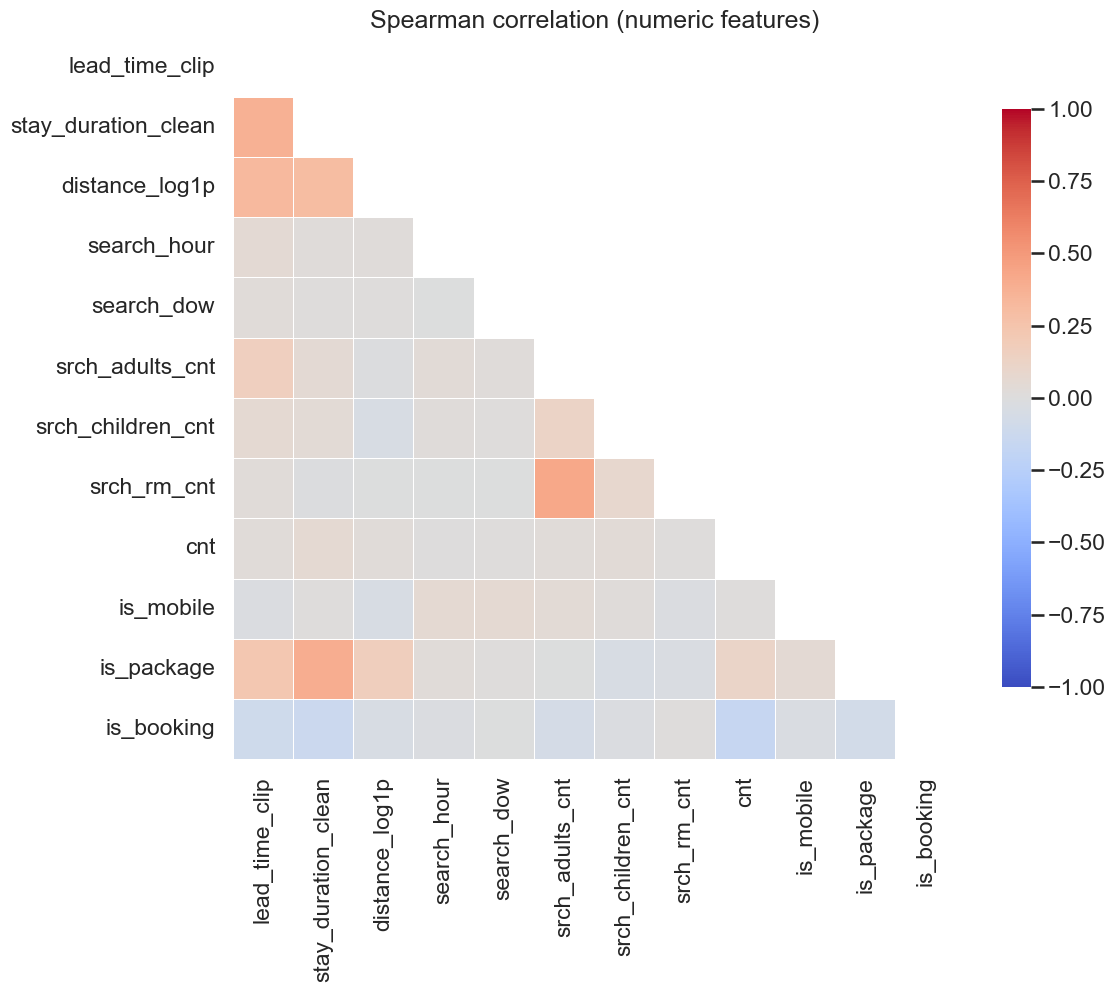


=== Correlation with is_booking (features only) ===
                     pearson_vs_is_booking  spearman_vs_is_booking
srch_rm_cnt                       0.010192                0.014921
search_dow                       -0.007838               -0.007254
search_hour                      -0.014656               -0.017202
srch_children_cnt                -0.020372               -0.015922
is_mobile                        -0.026923               -0.026923
distance_log1p                   -0.044579               -0.045703
srch_adults_cnt                  -0.045844               -0.065568
is_package                       -0.080306               -0.080306
lead_time_clip                   -0.081377               -0.108892
stay_duration_clean              -0.101722               -0.126184
cnt                              -0.113981               -0.161892


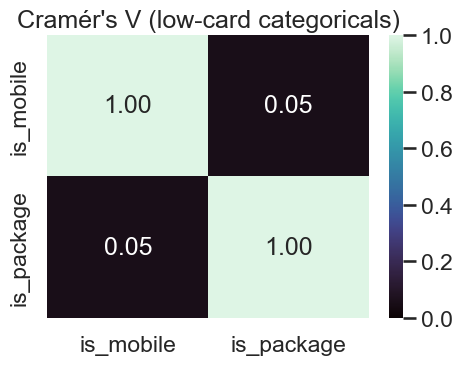


✅ Correlation figures saved to: /Users/katharinamohr/Documents/rina/AIPM/Group-3-Expedia-Hotel-Recommendation/figs


In [51]:
# Correlation Matrices
# ============================================
# What it does:
# - Build robust numeric features (lead_time, stay_duration, distance_log1p, etc.)
# - Downcast & sample to keep memory small
# - Compute Pearson & Spearman correlation matrices
# - Plot pretty triangular heatmaps
# - (Optional) Cramér's V for low-card categorical features
#
# pip install seaborn matplotlib pandas numpy

# ---------------- Config ----------------
OUT_DIR = "figs"
SAVE = True
SEED = 42
SAMPLE_N = 200_000   # stratified sample size (total); reduce if memory is tight
PALETTE = "coolwarm" # diverging colormap

os.makedirs(OUT_DIR, exist_ok=True)

sns.set_theme(style="white", context="talk")

# ------------- Load & features ----------
df = pd.read_csv("data/train_sample_1M.csv")

# Parse dates
for c in ["date_time", "srch_ci", "srch_co"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Normalize dates to midnight, then compute robust diffs (days)
dt = df["date_time"].dt.normalize()
ci = df["srch_ci"].dt.normalize()
co = df["srch_co"].dt.normalize()

df["lead_time"] = (ci - dt).dt.days
df["stay_duration"] = (co - ci).dt.days
df["search_hour"] = df["date_time"].dt.hour
df["search_dow"]  = df["date_time"].dt.dayofweek  # 0=Mon..6=Sun

# Clean ranges (keeps EDA stable)
df["lead_time_clip"]    = df["lead_time"].clip(lower=0, upper=540)
df["stay_duration_clean"] = df["stay_duration"].where(df["stay_duration"].between(1, 45), np.nan)

# Distance transforms
if "orig_destination_distance" in df.columns:
    df["orig_destination_distance"] = pd.to_numeric(df["orig_destination_distance"], errors="coerce")
    q01, q99 = df["orig_destination_distance"].quantile([0.01, 0.99])
    df["distance_clip"] = df["orig_destination_distance"].clip(q01, q99)
    df["distance_log1p"] = np.log1p(df["distance_clip"])

# Binarys as ints
for c in ["is_mobile", "is_package", "is_booking"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# --------- Choose numeric feature set ----
# Only include meaningful numeric signals (no high-card ID codes!)
num_feats = [
    "lead_time_clip",
    "stay_duration_clean",
    "distance_log1p",
    "search_hour",
    "search_dow",
    "srch_adults_cnt",
    "srch_children_cnt",
    "srch_rm_cnt",
    "cnt",            # session interactions; can be skewed but still numeric
    "is_mobile",
    "is_package",
    "is_booking",     # include target for corr with features
]

num_feats = [c for c in num_feats if c in df.columns]

# ------ Downcast to reduce memory footprint ------
for c in num_feats:
    if pd.api.types.is_float_dtype(df[c]):
        df[c] = df[c].astype("float32")
    elif pd.api.types.is_integer_dtype(df[c]):
        # keep Int64 (nullable) for binarys; for corr we can safely fill later
        pass

# ------ Sample (stratified by is_booking, if available) ------
def stratified_sample(frame, target_col="is_booking", n=SAMPLE_N, seed=SEED):
    if target_col not in frame.columns:
        return frame.sample(n=min(n, len(frame)), random_state=seed)
    parts = []
    # Split target into classes and sample proportionally
    for val, grp in frame.groupby(target_col, dropna=False):
        frac = len(grp) / len(frame)
        take = int(n * frac)
        parts.append(grp.sample(n=min(take, len(grp)), random_state=seed))
    out = pd.concat(parts, axis=0)
    # If rounding leaves us short, top up random rows
    if len(out) < n and len(frame) > len(out):
        extra = frame.drop(out.index).sample(n=min(n-len(out), len(frame)-len(out)), random_state=seed)
        out = pd.concat([out, extra], axis=0)
    return out

df_s = stratified_sample(df[num_feats].dropna(subset=["is_booking"]), target_col="is_booking")

# Safety: drop rows with all-NaN in selected features
df_s = df_s.dropna(how="all")

# ---------------- Correlations -----------
# Fill remaining NaNs with column medians (neutral for corr on large samples)
df_s_filled = df_s.copy()
for c in num_feats:
    if c != "is_booking":
        if df_s_filled[c].isna().any():
            df_s_filled[c] = df_s_filled[c].fillna(df_s_filled[c].median())

# Pearson (linear)
corr_pearson = df_s_filled.corr(method="pearson")
# Spearman (rank-based; robust to monotonic nonlinearity/outliers)
corr_spearman = df_s_filled.corr(method="spearman")

# ------------- Heatmap helper -----------
def plot_corr_heatmap(corr, title, fname):
    # mask upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        corr, mask=mask, cmap=PALETTE, vmin=-1, vmax=1, center=0,
        annot=False, square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=ax
    )
    ax.set_title(title)
    plt.tight_layout()
    if SAVE:
        fig.savefig(os.path.join(OUT_DIR, fname), dpi=160, bbox_inches="tight")
    plt.show()

plot_corr_heatmap(corr_pearson, "Pearson correlation (numeric features)", "corr_pearson.png")
plot_corr_heatmap(corr_spearman, "Spearman correlation (numeric features)", "corr_spearman.png")

# ---- Focus: correlation of features vs. is_booking ----
# (Point-biserial ≙ Pearson when one variable is binary)
if "is_booking" in df_s_filled.columns:
    corr_vs_target = corr_pearson["is_booking"].sort_values(ascending=False).to_frame("pearson_vs_is_booking")
    corr_vs_target["spearman_vs_is_booking"] = corr_spearman["is_booking"].sort_values(ascending=False)
    print("\n=== Correlation with is_booking (features only) ===")
    print(corr_vs_target.drop(index="is_booking"))

    # Optional: save this as CSV
    corr_vs_target.drop(index="is_booking").to_csv(os.path.join(OUT_DIR, "corr_vs_is_booking.csv"))

# ---------------- Optional: Cramér's V for categorical (low-card only) -------------
# Use for small-cardinality categoricals; do NOT use for high-card IDs (e.g., destination_id)
DO_CRAMERS_V = True
cat_cols = [c for c in ["is_mobile","is_package"] if c in df.columns]  # extend if you add low-card categoricals

def cramers_v(x, y):
    """Compute Cramér's V (bias-corrected) for two categorical series."""
    conf = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(conf, correction=False)[0]
    n = conf.values.sum()
    phi2 = chi2 / n
    r, k = conf.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr/denom) if denom > 0 else np.nan

if DO_CRAMERS_V and len(cat_cols) >= 2:
    import scipy.stats as ss
    # Build matrix
    M = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype="float64")
    for i, c1 in enumerate(cat_cols):
        for j, c2 in enumerate(cat_cols):
            if i == j:
                M.loc[c1, c2] = 1.0
            elif pd.isna(M.loc[c1, c2]):
                v = cramers_v(df[c1].dropna(), df[c2].dropna())
                M.loc[c1, c2] = M.loc[c2, c1] = v

    # Plot Cramér's V heatmap
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(M.astype(float), annot=True, fmt=".2f", vmin=0, vmax=1, cmap="mako", ax=ax)
    ax.set_title("Cramér's V (low-card categoricals)")
    plt.tight_layout()
    if SAVE:
        fig.savefig(os.path.join(OUT_DIR, "cramers_v_lowcard.png"), dpi=160, bbox_inches="tight")
    plt.show()

print("\n✅ Correlation figures saved to:", os.path.abspath(OUT_DIR))


# Booking behaviour & correlations

In [59]:
# Booking by Channel (Seaborn, performant)
# ==========================================
# - Computes booking rate per channel with Wilson 95% CI
# - Shows Top-N channels by volume
# - Optional: split by device (is_mobile) for comparison
# - Saves figures to ./figs
#
# Notes:
# * 'channel' is an anonymized marketing-channel ID (no public name mapping).
# * Use as categorical feature; avoid semantic assumptions per ID.

import os
import math
df = pd.read_csv('data/train_sample_1M.csv', usecols=["channel","is_booking","is_mobile"])
df["channel"] = pd.to_numeric(df["channel"], errors="coerce")
df["is_booking"] = pd.to_numeric(df["is_booking"], errors="coerce").astype("Int64")
df["is_mobile"] = pd.to_numeric(df["is_mobile"], errors="coerce").astype("Int64")

✅ Saved plots in: /Users/katharinamohr/Documents/rina/AIPM/Group-3-Expedia-Hotel-Recommendation/figs_deepdive
  channel   total  bookings  booking_rate_pct
9       9  554102     46626              8.41
0       0  124430      9160              7.36
1       1  101493      7039              6.94
2       2   78677      4789              6.09
5       5   61885      5728              9.26
3       3   44540      2525              5.67
4       4   21956      2922             13.31
7       7    8176       328              4.01
8       8    2985       244              8.17
6       6    1597        73              4.57


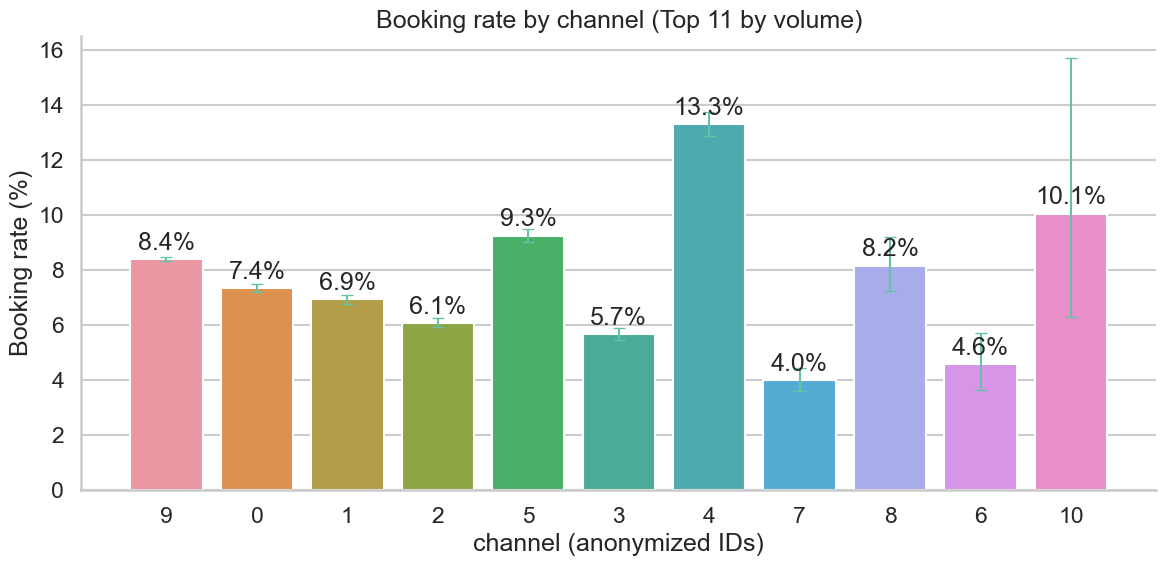

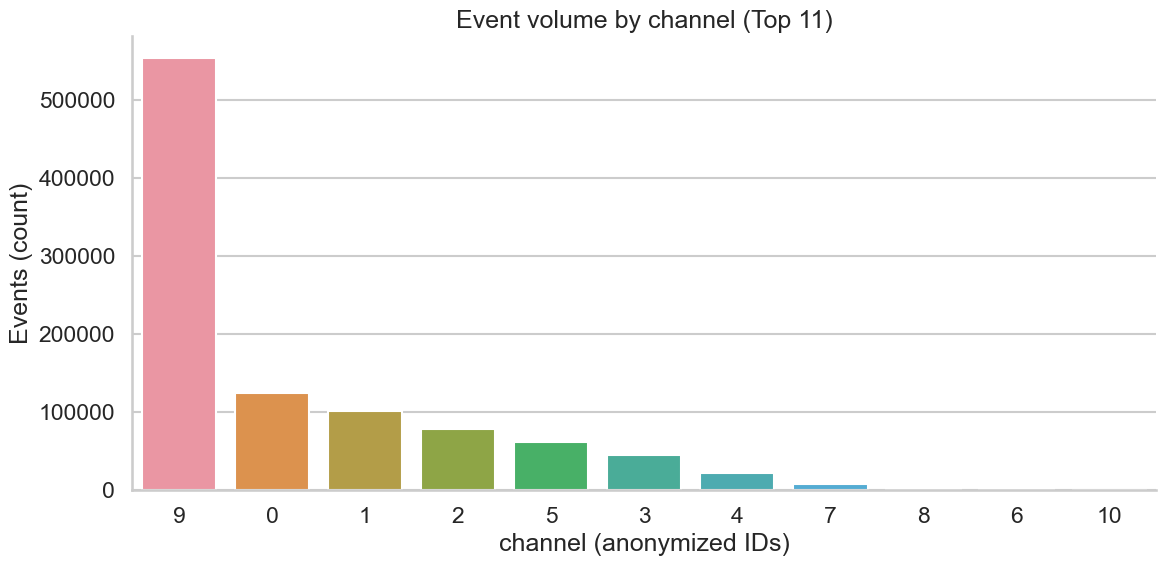

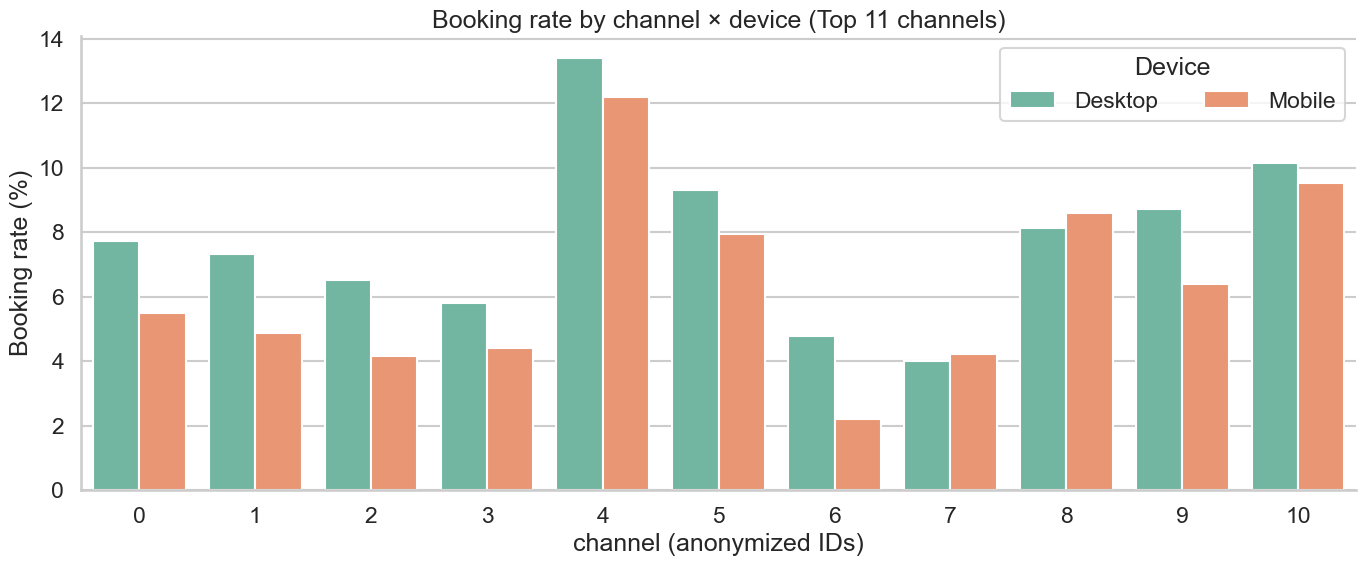

In [60]:
# ---------- Aggregate: booking rate per channel ----------
TOP_N = 11  # Number of top channels to display

agg = (
    df.dropna(subset=["channel","is_booking"])
      .groupby("channel", dropna=False)
      .agg(total=("is_booking","size"),
           bookings=("is_booking","sum"))
      .reset_index()
)
agg["booking_rate"] = agg["bookings"] / agg["total"]
agg["booking_rate_pct"] = (100 * agg["booking_rate"]).round(2)

# Wilson 95% CI for a binomial proportion (robust for small n)
def wilson_ci(p, n, z=1.96):
    if n == 0 or pd.isna(p):
        return (np.nan, np.nan)
    denom = 1 + z*z/n
    center = (p + z*z/(2*n)) / denom
    adj = z * math.sqrt((p*(1-p))/n + z*z/(4*n*n)) / denom
    return (max(0.0, center - adj), min(1.0, center + adj))

cis = agg.apply(lambda r: wilson_ci(r["booking_rate"], r["total"]), axis=1)
agg["ci_low"]  = [c[0] for c in cis]
agg["ci_high"] = [c[1] for c in cis]
agg["ci_low_pct"]  = 100 * agg["ci_low"]
agg["ci_high_pct"] = 100 * agg["ci_high"]

# Select Top-N by volume
top = agg.sort_values("total", ascending=False).head(TOP_N).copy()
top["channel"] = top["channel"].astype(int).astype(str)  # nicer x-axis labels

# ---------- Plot 1: Booking rate by channel (Top-N) ----------
fig, ax = plt.subplots(figsize=(12, 6))
bar = sns.barplot(data=top, x="channel", y="booking_rate_pct", ax=ax)
ax.set_title(f"Booking rate by channel (Top {TOP_N} by volume)")
ax.set_xlabel("channel (anonymized IDs)")
ax.set_ylabel("Booking rate (%)")

# Add Wilson error bars
xticks = ax.get_xticks()
for x, (_, r) in zip(xticks, top.iterrows()):
    y = r["booking_rate_pct"]
    low = r["ci_low_pct"]; high = r["ci_high_pct"]
    err_low = y - low
    err_high = high - y
    ax.errorbar(x, y, yerr=[[err_low],[err_high]], fmt="none", capsize=4, lw=1.5)

# Add % labels on bars (fallback-safe)
try:
    ax.bar_label(bar.containers[0], fmt="%.1f%%", padding=3)
except Exception:
    pass

sns.despine()
fig.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "booking_rate_by_channel_topN.png"), dpi=160)

# ---------- Plot 2 (optional): Volume by channel (Top-N, log scale if skewed) ----------
fig2, ax2 = plt.subplots(figsize=(12, 6))
bar2 = sns.barplot(data=top, x="channel", y="total", ax=ax2)
ax2.set_title(f"Event volume by channel (Top {TOP_N})")
ax2.set_xlabel("channel (anonymized IDs)")
ax2.set_ylabel("Events (count)")
# If extremely skewed, uncomment:
# ax2.set_yscale("log")
sns.despine()
fig2.tight_layout()
fig2.savefig(os.path.join(OUT_DIR, "volume_by_channel_topN.png"), dpi=160)

# ---------- Plot 3 (optional): Booking rate by channel × device ----------
# Keep only channels in Top-N for readability
mob = (
    df.dropna(subset=["channel","is_booking","is_mobile"])
      .copy()
)
mob["channel"] = mob["channel"].astype(int)
mob_top = mob[mob["channel"].isin(top["channel"].astype(int))]

mob_agg = (
    mob_top.groupby(["channel","is_mobile"])
           .agg(total=("is_booking","size"),
                bookings=("is_booking","sum"))
           .reset_index()
)
mob_agg["booking_rate_pct"] = (100 * mob_agg["bookings"] / mob_agg["total"]).round(2)
mob_agg["channel"] = mob_agg["channel"].astype(str)
mob_agg["device"] = mob_agg["is_mobile"].map({0:"Desktop", 1:"Mobile"}).fillna("Unknown")

fig3, ax3 = plt.subplots(figsize=(14, 6))
sns.barplot(data=mob_agg, x="channel", y="booking_rate_pct", hue="device", ax=ax3)
ax3.set_title(f"Booking rate by channel × device (Top {TOP_N} channels)")
ax3.set_xlabel("channel (anonymized IDs)")
ax3.set_ylabel("Booking rate (%)")
ax3.legend(title="Device", ncols=2, loc="upper right")
sns.despine()
fig3.tight_layout()
fig3.savefig(os.path.join(OUT_DIR, "booking_rate_by_channel_by_device.png"), dpi=160)

print("✅ Saved plots in:", os.path.abspath(OUT_DIR))
print(top.sort_values("total", ascending=False).head(10)[["channel","total","bookings","booking_rate_pct"]])

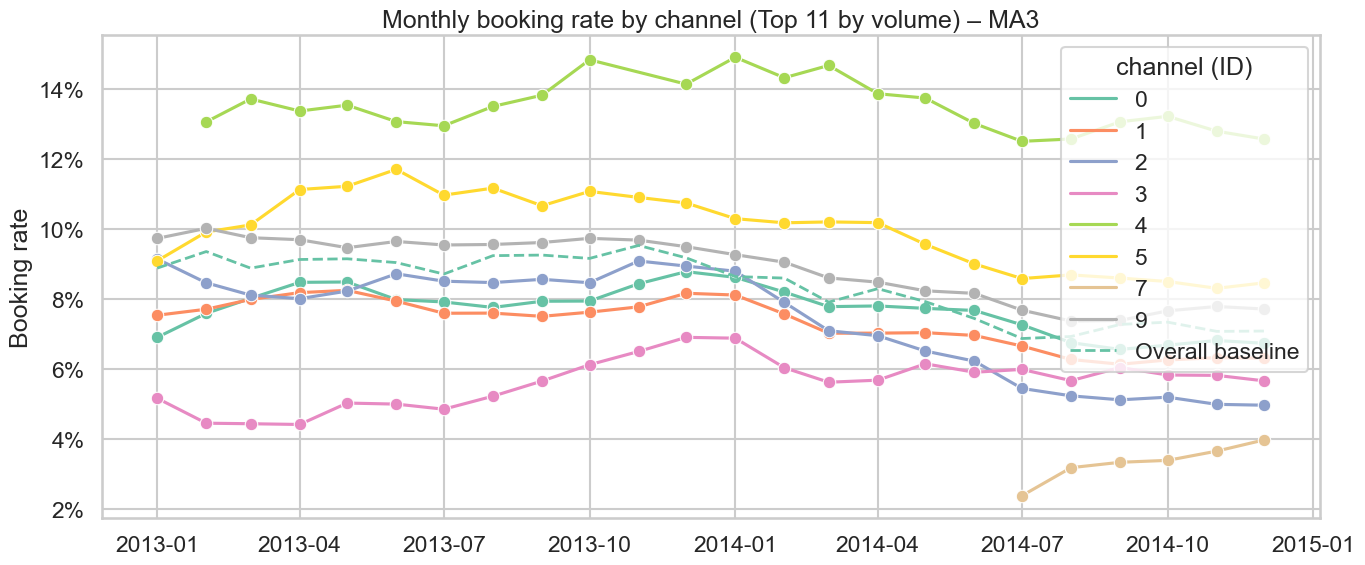

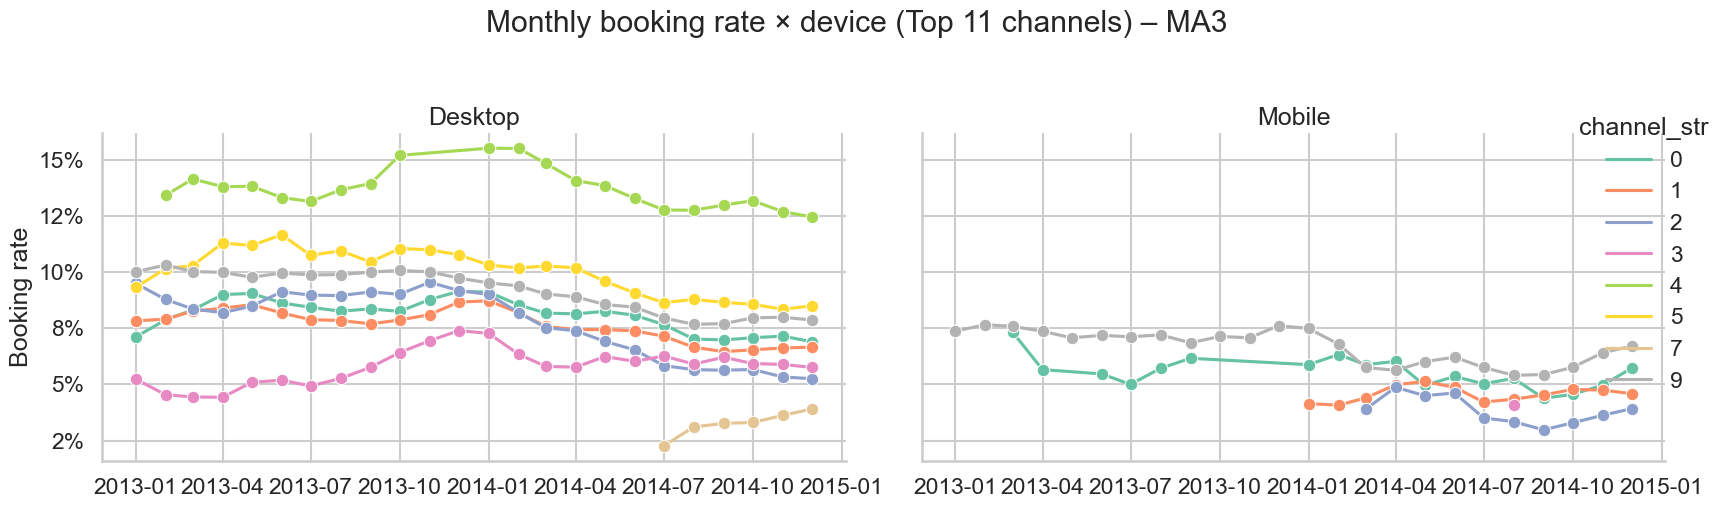

In [61]:
# Time Series: Monthly Booking Rate by Channel (Top-N)
# ============================================================

# ---------- Config ----------
TOP_N_TS = 11            # how many channels to plot (by overall volume)
MIN_EVENTS_PER_MONTH = 500   # filter sparse month×channel cells
SMOOTH_MA = 3           # rolling window in months (set to 1 to disable)
OUT_DIR = "figs"        # same folder as before
sns.set_theme(style="whitegrid", context="talk", palette="Set2")

# ---------- Load minimal columns (reuse df if already loaded) ----------
# If 'df' not present, uncomment next 2 lines:
df = pd.read_csv("data/train_sample_1M.csv", usecols=["date_time","channel","is_booking","is_mobile"])
df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")

# Ensure numeric types
df["channel"] = pd.to_numeric(df["channel"], errors="coerce")
df["is_booking"] = pd.to_numeric(df["is_booking"], errors="coerce").astype("Int64")
df["is_mobile"] = pd.to_numeric(df["is_mobile"], errors="coerce").astype("Int64")

# Month key (period → timestamp at month start for clean x-axis)
df = df.dropna(subset=["date_time", "channel", "is_booking"]).copy()
df["month"] = df["date_time"].dt.to_period("M").dt.to_timestamp(how="start")

# ---------- Pick Top-N channels by overall volume ----------
vol = df["channel"].value_counts(dropna=False).sort_values(ascending=False)
top_channels = vol.head(TOP_N_TS).index.tolist()

# ---------- Aggregate monthly booking rates ----------
ts = (
    df[df["channel"].isin(top_channels)]
      .groupby(["month","channel"], as_index=False)
      .agg(total=("is_booking","size"),
           bookings=("is_booking","sum"))
)
ts["rate"] = ts["bookings"] / ts["total"]
# Filter sparse month×channel buckets
ts = ts[ts["total"] >= MIN_EVENTS_PER_MONTH].copy()

# Optional smoothing (rolling 3-month avg per channel)
if SMOOTH_MA and SMOOTH_MA > 1:
    ts = ts.sort_values(["channel","month"])
    ts["rate_ma"] = (
        ts.groupby("channel")["rate"]
          .transform(lambda s: s.rolling(SMOOTH_MA, min_periods=1).mean())
    )
    ycol = "rate_ma"
else:
    ycol = "rate"

# For nice labels
ts["channel_str"] = ts["channel"].astype(int).astype(str)

# ---------- Global baseline per month (all channels) ----------
baseline = (
    df.groupby("month", as_index=False)
      .agg(total=("is_booking","size"),
           bookings=("is_booking","sum"))
)
baseline["rate"] = baseline["bookings"] / baseline["total"]

# ---------- Plot A: Monthly booking rate by channel (Top-N) ----------
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(data=ts, x="month", y=ycol, hue="channel_str", marker="o", ax=ax)
# Add baseline as dashed reference
sns.lineplot(data=baseline, x="month", y="rate", ax=ax, linestyle="--", linewidth=2, label="Overall baseline")

ax.set_title(f"Monthly booking rate by channel (Top {TOP_N_TS} by volume){' – MA'+str(SMOOTH_MA) if ycol=='rate_ma' else ''}")
ax.set_xlabel("")
ax.set_ylabel("Booking rate")
ax.yaxis.set_major_formatter(lambda v, pos: f"{v*100:.0f}%")
ax.legend(title="channel (ID)")
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "ts_booking_rate_by_channel_topN.png"), dpi=160)
plt.show()

# ============================================================
# OPTIONAL: Device split (Desktop vs Mobile) for the same Top-N
# ============================================================
dm = (
    df[df["channel"].isin(top_channels)]
      .dropna(subset=["is_mobile"])
      .groupby(["month","channel","is_mobile"], as_index=False)
      .agg(total=("is_booking","size"),
           bookings=("is_booking","sum"))
)
dm["rate"] = dm["bookings"] / dm["total"]
dm = dm[dm["total"] >= MIN_EVENTS_PER_MONTH].copy()
if SMOOTH_MA and SMOOTH_MA > 1:
    dm = dm.sort_values(["channel","is_mobile","month"])
    dm["rate_ma"] = (
        dm.groupby(["channel","is_mobile"])["rate"]
          .transform(lambda s: s.rolling(SMOOTH_MA, min_periods=1).mean())
    )
    ycol_dm = "rate_ma"
else:
    ycol_dm = "rate"

dm["channel_str"] = dm["channel"].astype(int).astype(str)
dm["device"] = dm["is_mobile"].map({0:"Desktop", 1:"Mobile"}).fillna("Unknown")

g = sns.relplot(
    data=dm, kind="line", x="month", y=ycol_dm,
    hue="channel_str", col="device", marker="o",
    height=5, aspect=1.6, facet_kws=dict(sharey=True)
)
g.set_axis_labels("", "Booking rate")
g.set_titles(col_template="{col_name}")
# Format y-axis as percentages
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(lambda v, pos: f"{v*100:.0f}%")
g.fig.suptitle(f"Monthly booking rate × device (Top {TOP_N_TS} channels){' – MA'+str(SMOOTH_MA) if ycol_dm=='rate_ma' else ''}", y=1.03)
plt.tight_layout()
g.savefig(os.path.join(OUT_DIR, "ts_booking_rate_by_channel_by_device.png"), dpi=160)
plt.show()

In [62]:
# Deep-Dive Booking Behavior EDA (Seaborn, performant)
# ============================================================

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold

# ----------------- Config -----------------
SEED = 42
OUT_DIR = "figs_deepdive"
SAMPLE_HEATMAP = 250_000    # for heavy 2D grids
BINS_NUMERIC = 10           # default bin count for numeric binning
sns.set_theme(style="whitegrid", context="talk", palette="Set2")
os.makedirs(OUT_DIR, exist_ok=True)
# ------------------------------------------

df = pd.read_csv("data/train_sample_1M.csv")

# Dates
for c in ["date_time","srch_ci","srch_co"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")
dt = df["date_time"].dt.normalize()
ci = df["srch_ci"].dt.normalize()
co = df["srch_co"].dt.normalize()

# Core features
df["lead_time"] = (ci - dt).dt.days
df["stay_duration"] = (co - ci).dt.days
df["search_hour"] = df["date_time"].dt.hour
df["search_dow"]  = df["date_time"].dt.dayofweek
df["weekday"] = df["search_dow"].map({0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"})

# Clean ranges for stability
df["lead_time_clip"] = df["lead_time"].clip(0, 540)
df["stay_duration_clean"] = df["stay_duration"].where(df["stay_duration"].between(1,45))
if "orig_destination_distance" in df.columns:
    df["orig_destination_distance"] = pd.to_numeric(df["orig_destination_distance"], errors="coerce")
    q01, q99 = df["orig_destination_distance"].quantile([0.01, 0.99])
    df["distance_clip"] = df["orig_destination_distance"].clip(q01, q99)
    df["distance_log1p"] = np.log1p(df["distance_clip"])

for c in ["is_booking","is_mobile","is_package"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

In [63]:
# ----------------- Helpers -----------------
def qbin(s: pd.Series, q=BINS_NUMERIC, labels=None):
    """Quantile binning with safe unique edges."""
    if s.isna().all():
        return pd.Series(index=s.index, dtype="category")
    qs = s.quantile(np.linspace(0,1,q+1)).values
    edges = np.unique(qs)
    # fallback: if too few unique edges, use fixed bins
    if len(edges) < 3:
        mi, ma = s.min(), s.max()
        edges = np.linspace(mi, ma, q+1)
    if labels is None:
        labels = [f"B{i+1}" for i in range(len(edges)-1)]
    return pd.cut(s, bins=edges, labels=labels, include_lowest=True, ordered=True)

def booking_rate_pivot(frame, row, col, min_count=300):
    """
    Build booking-rate grid for heatmaps.
    row/col should be already binned or low-card categoricals.
    Returns (pivot_df_float, grouped_df)
    """
    tmp = frame[[row, col, "is_booking"]].dropna()
    agg = (
        tmp.groupby([row, col], observed=True)
           .agg(total=("is_booking","size"),
                bookings=("is_booking","sum"))
           .reset_index()
    )
    agg = agg[agg["total"] >= min_count]
    # Force pure numpy float (not pandas Float64/Int64)
    agg["rate"] = (agg["bookings"].astype("float64") / agg["total"].astype("float64")).astype("float64")

    pv = agg.pivot(index=row, columns=col, values="rate")
    pv = pv.astype("float64")  # ensure numeric matrix for seaborn
    return pv, agg

def plot_heatmap(pivot, title, fname, fmt_pct=True, vmin=0.0, vmax=100.0):
    data = pivot.astype("float64").copy()
    data = data.dropna(how="all").dropna(axis=1, how="all")
    if data.empty:
        print(f"[plot_heatmap] Nothing to plot: {title}")
        return
    if fmt_pct:
        data = data * 100.0
    mask = data.isna()
    fig, ax = plt.subplots(figsize=(1.0*max(8, data.shape[1]*0.7),
                                    1.0*max(6, data.shape[0]*0.6)))
    sns.heatmap(data, mask=mask, cmap="viridis",
                vmin=vmin, vmax=vmax,
                cbar_kws={"label":"Booking rate (%)"}, ax=ax)
    ax.set_title(title); ax.set_xlabel(""); ax.set_ylabel("")
    plt.tight_layout(); fig.savefig(os.path.join(OUT_DIR, fname), dpi=160); plt.show()



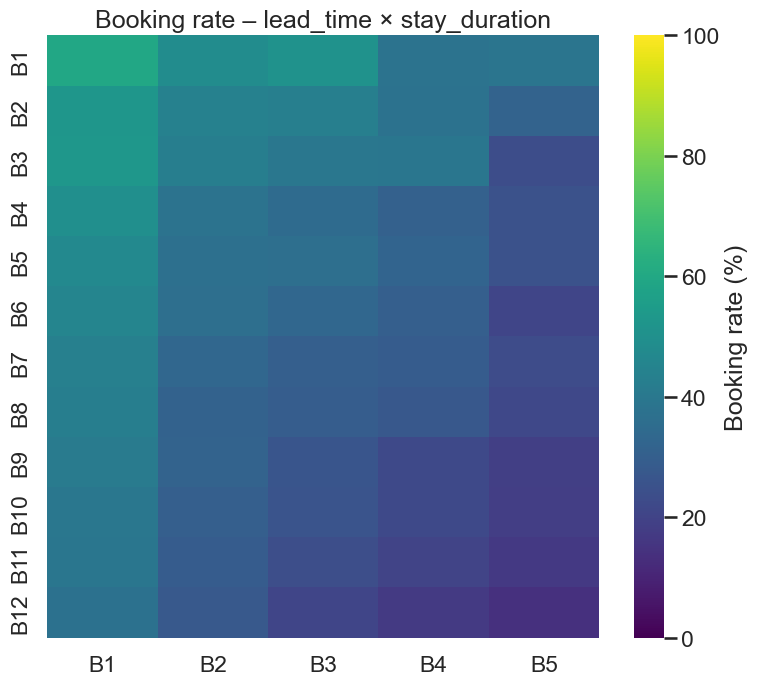

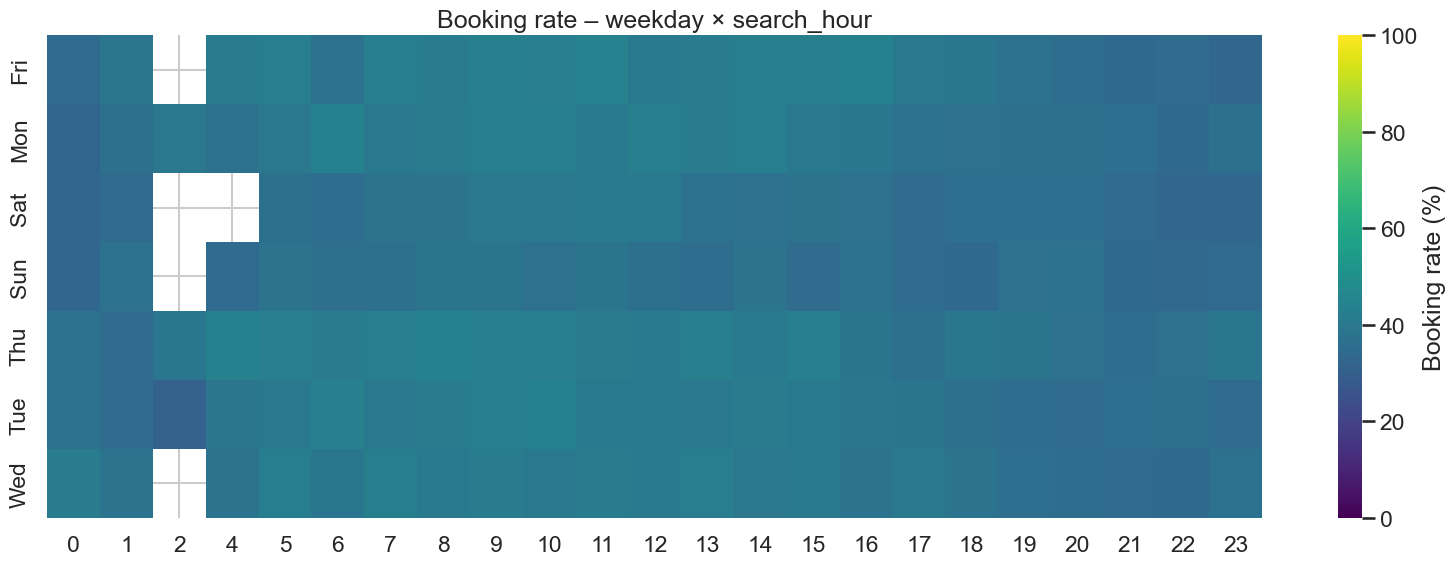

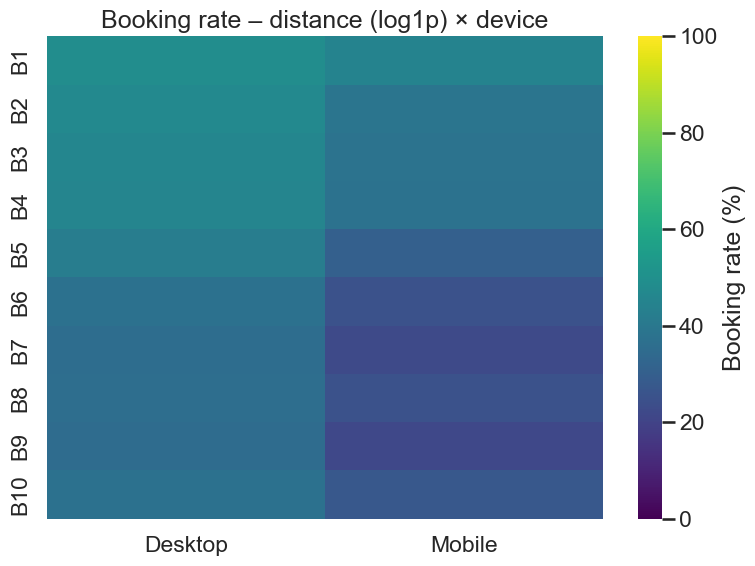

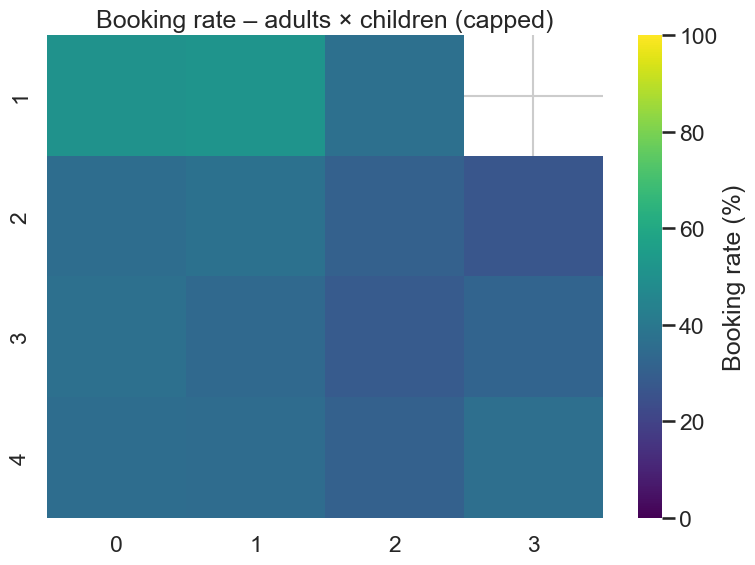

In [64]:
# INTERACTION HEATMAPS
# Use a stratified sample for speed
def strat_sample(frame, per_class=125_000, cols=None):
    if cols is None: cols = frame.columns
    parts = []
    for v, g in frame.groupby("is_booking", dropna=False):
        n = min(per_class, len(g))
        parts.append(g[cols].sample(n=n, random_state=SEED))
    return pd.concat(parts).sample(frac=1.0, random_state=SEED)

cols_for_heat = ["lead_time_clip","stay_duration_clean","weekday","search_hour",
                 "distance_log1p","is_mobile","srch_adults_cnt","srch_children_cnt"]
cols_for_heat = [c for c in cols_for_heat if c in df.columns]
dfs = strat_sample(df.dropna(subset=["is_booking"])[cols_for_heat+["is_booking"]],
                   per_class=SAMPLE_HEATMAP//2, cols=cols_for_heat+["is_booking"])

# a) lead_time × stay_duration
dfs["lead_bin"] = qbin(dfs["lead_time_clip"], q=12)
dfs["stay_bin"] = qbin(dfs["stay_duration_clean"], q=10)
pv, _ = booking_rate_pivot(dfs, "lead_bin", "stay_bin")
plot_heatmap(pv, "Booking rate – lead_time × stay_duration", "hm_rate_lead_stay.png")

# b) weekday × hour (refined Version with hours)
pv2, _ = booking_rate_pivot(dfs, "weekday", "search_hour")
plot_heatmap(pv2, "Booking rate – weekday × search_hour", "hm_rate_weekday_hour.png")

# c) distance × device (if distance is available)
if "distance_log1p" in dfs.columns and "is_mobile" in dfs.columns:
    dfs["dist_bin"] = qbin(dfs["distance_log1p"], q=10)
    dfs["device"] = dfs["is_mobile"].map({0:"Desktop",1:"Mobile"}).astype("category")
    pv3, _ = booking_rate_pivot(dfs.dropna(subset=["device"]), "dist_bin", "device")
    plot_heatmap(pv3, "Booking rate – distance (log1p) × device", "hm_rate_distance_device.png")

# d) adults × children (families vs. couples)
if "srch_adults_cnt" in dfs.columns and "srch_children_cnt" in dfs.columns:
    # cap high counts to keep grid compact
    ds = dfs.copy()
    ds["adults_c"] = ds["srch_adults_cnt"].clip(1, 4).astype(int)
    ds["children_c"] = ds["srch_children_cnt"].clip(0, 3).astype(int)
    pv4, _ = booking_rate_pivot(ds, "adults_c", "children_c")
    plot_heatmap(pv4, "Booking rate – adults × children (capped)", "hm_rate_adults_children.png")



=== Mutual Information w.r.t is_booking ===
                feature  mutual_info
7           srch_rm_cnt     0.037517
8                   cnt     0.033228
5       srch_adults_cnt     0.028272
1   stay_duration_clean     0.012992
0        lead_time_clip     0.007645
4            search_dow     0.005761
10           is_package     0.003497
3           search_hour     0.002318
2        distance_log1p     0.002118
6     srch_children_cnt     0.002006
9             is_mobile     0.000524


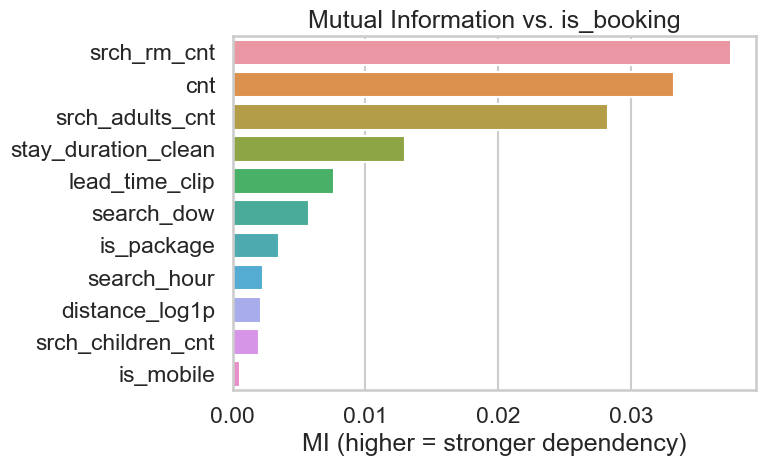

In [65]:
# MUTUAL INFORMATION (vs is_booking) 
# Numeric candidates (avoid high-card IDs)
mi_features = [c for c in [
    "lead_time_clip","stay_duration_clean","distance_log1p",
    "search_hour","search_dow","srch_adults_cnt","srch_children_cnt",
    "srch_rm_cnt","cnt","is_mobile","is_package"
] if c in df.columns]

mi_frame = df[mi_features + ["is_booking"]].dropna()
# MI expects arrays; for speed you can sample here if needed
mi_sample = mi_frame.sample(n=min(200_000, len(mi_frame)), random_state=SEED)
X = mi_sample[mi_features].copy()
y = mi_sample["is_booking"].astype(int).values

# Fill NaNs
for c in mi_features:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())

mi = mutual_info_classif(X.values, y, random_state=SEED, discrete_features=[mi_features.index(c) for c in ["is_mobile","is_package"] if c in mi_features])
mi_tbl = pd.DataFrame({"feature": mi_features, "mutual_info": mi}).sort_values("mutual_info", ascending=False)
print("\n=== Mutual Information w.r.t is_booking ===")
print(mi_tbl)

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=mi_tbl, x="mutual_info", y="feature", ax=ax)
ax.set_title("Mutual Information vs. is_booking")
ax.set_xlabel("MI (higher = stronger dependency)")
ax.set_ylabel("")
plt.tight_layout(); fig.savefig(os.path.join(OUT_DIR, "mi_vs_is_booking.png"), dpi=160); plt.show()


In [66]:
# ----------------- 3) WOE / IV (binned numerics) -----------------
def woe_iv_for_numeric(frame, col, target="is_booking", bins=10):
    d = frame[[col, target]].dropna().copy()
    d["bin"] = qbin(d[col], q=bins)
    g = d.groupby("bin").agg(events=(target,"sum"), total=(target,"size"))
    g["non_events"] = g["total"] - g["events"]
    # proportions
    E = g["events"].sum(); NE = g["non_events"].sum()
    g["dist_events"] = (g["events"] / E).replace(0, 1e-12)
    g["dist_nonevents"] = (g["non_events"] / NE).replace(0, 1e-12)
    g["woe"] = np.log(g["dist_events"] / g["dist_nonevents"])
    g["iv"] = (g["dist_events"] - g["dist_nonevents"]) * g["woe"]
    return g.reset_index(), g["iv"].sum()

woe_candidates = [c for c in ["lead_time_clip","stay_duration_clean","distance_log1p","cnt"] if c in df.columns]
iv_rows = []
for col in woe_candidates:
    tbl, iv = woe_iv_for_numeric(df, col)
    iv_rows.append({"feature": col, "IV": iv})
    # optional: save per-bin table
    tbl.to_csv(os.path.join(OUT_DIR, f"woe_{col}.csv"), index=False)
iv_tbl = pd.DataFrame(iv_rows).sort_values("IV", ascending=False)
print("\n=== Information Value (binned) ===")
print(iv_tbl)


=== Information Value (binned) ===
               feature        IV
3                  cnt  0.552880
1  stay_duration_clean  0.204713
0       lead_time_clip  0.167801
2       distance_log1p  0.049460


In [67]:
# ----------------- 4) Target Encoding Diagnostics (no leakage) -----------------
# Smoothed mean encoding for high-card categorical (diagnostic only)
def smoothed_target_mean(frame, col, target="is_booking", m=50):
    """Return per-category smoothed mean: (sum_y + m*global) / (n + m)."""
    g = frame.groupby(col)[target].agg(["sum","count"])
    global_mean = frame[target].mean()
    enc = (g["sum"] + m * global_mean) / (g["count"] + m)
    return enc

# Example: srch_destination_id (if present)
if "srch_destination_id" in df.columns:
    # Use KFold to avoid leakage when *evaluating* encoding quality
    te_col = "srch_destination_id"
    sub = df[[te_col,"is_booking"]].dropna().copy()
    sub[te_col] = sub[te_col].astype(int)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    corrs = []
    for tr, va in kf.split(sub):
        tr_df, va_df = sub.iloc[tr], sub.iloc[va]
        enc = smoothed_target_mean(tr_df, te_col, "is_booking", m=100)
        va_df = va_df.copy()
        va_df["te"] = va_df[te_col].map(enc)
        corrs.append(va_df[["te","is_booking"]].corr().iloc[0,1])
    print(f"\nTarget encoding CV-correlation for {te_col}: mean={np.nanmean(corrs):.4f}, std={np.nanstd(corrs):.4f}")


Target encoding CV-correlation for srch_destination_id: mean=0.1245, std=0.0024


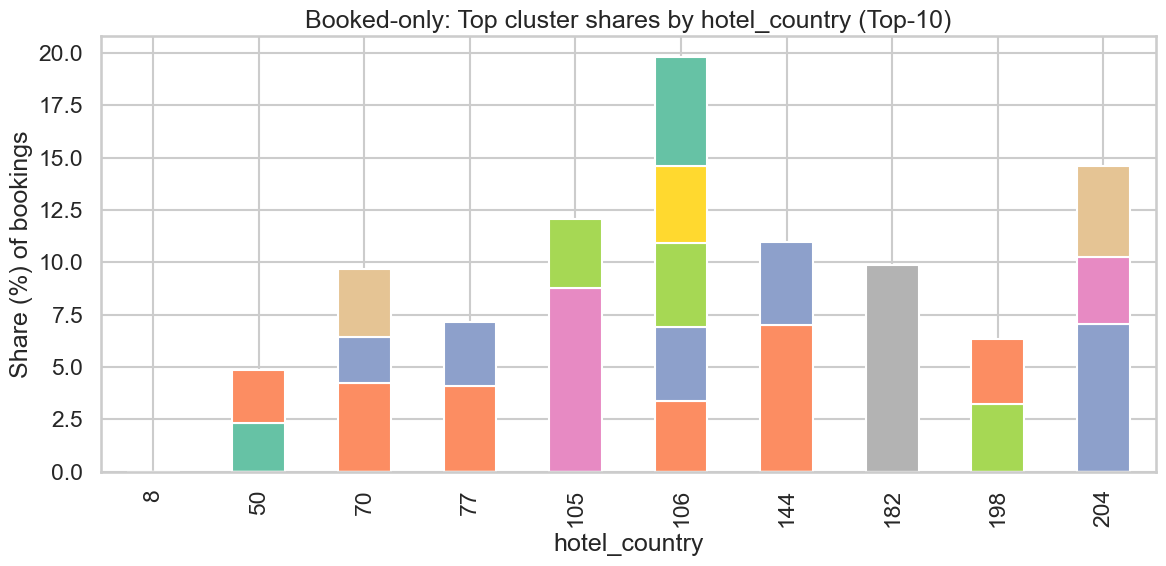

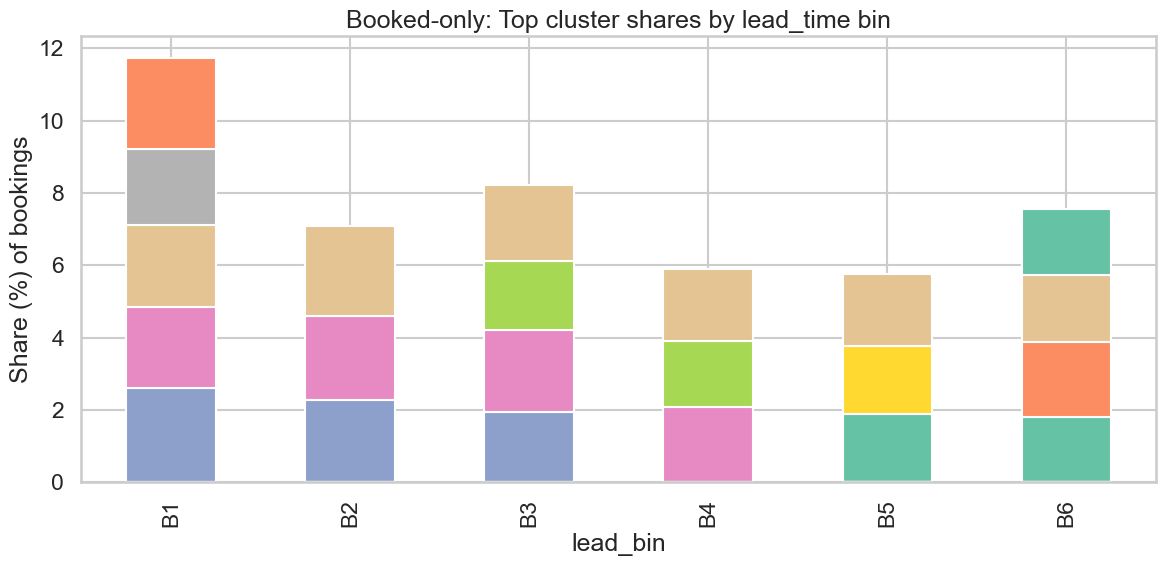

In [68]:
# ----------------- 5) BOOKED-ONLY: Cluster distributions by segment -----------------
# Helps for Stage-2 (predict cluster among booked)
if "hotel_cluster" in df.columns:
    booked = df[df["is_booking"] == 1].copy()
    booked["lead_bin"] = qbin(booked["lead_time_clip"], q=6)
    booked["stay_bin"] = qbin(booked["stay_duration_clean"], q=6)

    def top_clusters_by(group_col, top_k=10):
        g = (booked.dropna(subset=[group_col,"hotel_cluster"])
                    .groupby([group_col,"hotel_cluster"])
                    .size().reset_index(name="cnt"))
        # share within group
        g["share"] = g.groupby(group_col)["cnt"].transform(lambda x: x / x.sum())
        # top clusters per group
        tops = (g.sort_values(["{0}".format(group_col),"share"], ascending=[True,False])
                  .groupby(group_col).head(top_k))
        return tops

    # Example A: by hotel_country (Top-5 countries by volume)
    if "hotel_country" in booked.columns:
        top10 = booked["hotel_country"].value_counts().head(10).index
        top_country = top_clusters_by("hotel_country", top_k=10)
        top_country = top_country[top_country["hotel_country"].isin(top10)]
        # Plot stacked bars per country (top clusters)
        fig, ax = plt.subplots(figsize=(12,6))
        # pivot to cluster shares columns
        pv = top_country.pivot(index="hotel_country", columns="hotel_cluster", values="share").fillna(0)
        (100*pv.iloc[:, :10]).plot(kind="bar", stacked=True, ax=ax, legend=False)
        ax.set_title("Booked-only: Top cluster shares by hotel_country (Top-10)")
        ax.set_ylabel("Share (%) of bookings")
        plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "booked_top_clusters_by_country.png"), dpi=160); plt.show()

    # Example B: by lead_time bins (which clusters win for short vs long planning?)
    top_lead = top_clusters_by("lead_bin", top_k=10)
    fig, ax = plt.subplots(figsize=(12,6))
    pv2 = top_lead.pivot(index="lead_bin", columns="hotel_cluster", values="share").fillna(0)
    (100*pv2.iloc[:, :10]).plot(kind="bar", stacked=True, ax=ax, legend=False)
    ax.set_title("Booked-only: Top cluster shares by lead_time bin")
    ax.set_ylabel("Share (%) of bookings")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "booked_top_clusters_by_leadbin.png"), dpi=160); plt.show()

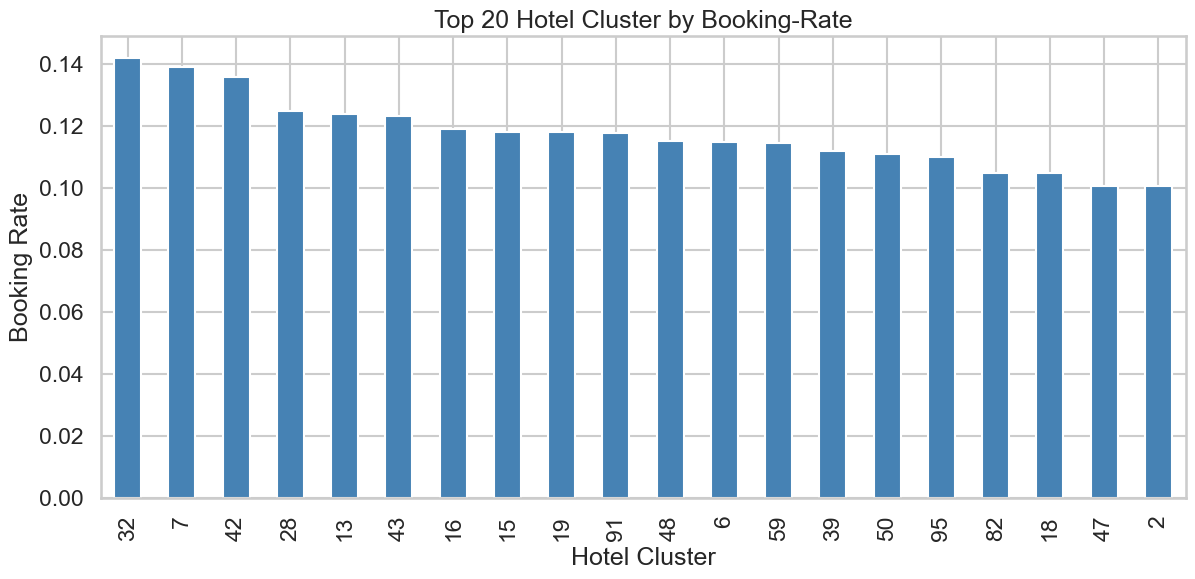

In [69]:
df = pd.read_csv("data/train_sample_1M.csv")

# Aggregation: calculate by Cluster Booking-Rate
cluster_bookings = (
    df.groupby("hotel_cluster")["is_booking"]
      .mean()
      .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(14,6))
cluster_bookings.head(20).plot(kind="bar", color="steelblue")  # Top 20
plt.title("Top 20 Hotel Cluster by Booking-Rate")
plt.xlabel("Hotel Cluster")
plt.ylabel("Booking Rate")
plt.show()


# User analysis (booking vs. non-booking)

In [70]:
# check how many unique user IDs?
n_users = df["user_id"].nunique()
print("Number of unique users:", n_users)

# count events per user
user_counts = df.groupby("user_id")["is_booking"].agg(["count", "sum"])
user_counts.rename(columns={"count": "total_events", "sum": "total_bookings"}, inplace=True)

# Percentage of users with at least 1 booking
booking_users = (user_counts["total_bookings"] > 0).mean()
print("Percentage of users who completed booking:", booking_users)

# Beispiel: User, die erst suchen (0) und irgendwann buchen (1)
# dafür sortieren wir pro User nach Zeit (hier: srch_ci oder date_time nutzen)
df_sorted = df.sort_values(["user_id", "date_time"])

# Pro User schauen: gab es zuerst 0 und dann 1?
def has_search_then_book(group):
    return (group["is_booking"].cumsum().shift(fill_value=0) == 0).any() and (group["is_booking"].sum() > 0)

user_patterns = df_sorted.groupby("user_id").apply(has_search_then_book)
print("Pecentage of users with separate search events before booking:", user_patterns.mean())

Number of unique users: 488931
Percentage of users who completed booking: 0.14388737879169045
Pecentage of users with separate search events before booking: 0.14388737879169045


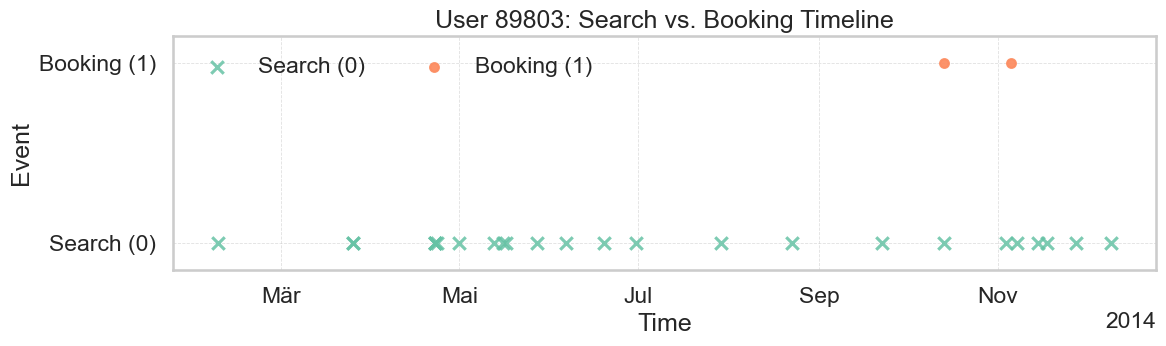

In [71]:
# --- Readable user timeline plot (pure matplotlib; no seaborn) ---
# Goal: show searches (0) vs bookings (1) over time for one user, clearly.

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_user_timeline(df, user_id=None, title_prefix="User"):
    """
    Create a clean, readable timeline of Search(0) vs Booking(1) for a single user.
    - Uses concise date formatting
    - Limits number of x-ticks
    - Separate markers for searches and bookings
    """
    # 1) Basic column checks
    required = {"user_id", "date_time", "is_booking"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    # 2) Parse datetime if needed and sort
    if not pd.api.types.is_datetime64_any_dtype(df["date_time"]):
        df = df.copy()
        df["date_time"] = pd.to_datetime(df["date_time"], errors="coerce")
    df = df.dropna(subset=["date_time"])

    # 3) Pick a user (given, or most-active fallback)
    if user_id is None:
        user_id = df["user_id"].value_counts().idxmax()

    dfu = (
        df.loc[df["user_id"] == user_id, ["date_time", "is_booking"]]
          .sort_values("date_time")
    )
    if dfu.empty:
        raise ValueError(f"No rows found for user_id={user_id}")

    # 4) Split searches vs bookings for clearer markers
    searches = dfu[dfu["is_booking"] == 0]
    bookings = dfu[dfu["is_booking"] == 1]

    # 5) Plot
    fig, ax = plt.subplots(figsize=(12, 3.8))

    # Use different markers; keep default colors to follow the rules
    ax.scatter(searches["date_time"], searches["is_booking"],
               marker="x", alpha=0.85, label="Search (0)")
    ax.scatter(bookings["date_time"], bookings["is_booking"],
               marker="o", s=40, alpha=0.95, label="Booking (1)")

    # 6) Y-axis as categories (0/1 with labels)
    ax.set_ylim(-0.15, 1.15)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Search (0)", "Booking (1)"])

    # 7) Tidy X-axis: concise date formatting with fewer ticks
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # 8) Labels, grid, legend
    ax.set_title(f"{title_prefix} {user_id}: Search vs. Booking Timeline")
    ax.set_xlabel("Time")
    ax.set_ylabel("Event")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
    ax.legend(loc="upper left", ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# ===== Example usage =====
# 1) Load (adjust path to your file)
# df = pd.read_csv("train_sample_1M.csv", low_memory=False)

# 2) Call the function
plot_user_timeline(df, user_id=89803)   # or leave out user_id to pick the most active user


In [72]:
# For user 89803: show both search and booking events, with hotel_cluster
df_user_events = df.loc[df["user_id"] == 89803, 
                        ["date_time", "hotel_cluster", "is_booking"]].sort_values("date_time")

# Map is_booking: 0=Search, 1=Booking
df_user_events["event_type"] = df_user_events["is_booking"].map({0: "Search", 1: "Booking"})

# Show first 25 rows as preview
df_user_events.head(30)


,date_time,hotel_cluster,is_booking,event_type
75055,2014-02-07 10:56:13,46,0,Search
75056,2014-03-25 11:22:23,20,0,Search
75057,2014-03-25 18:25:14,2,0,Search
75058,2014-04-22 12:37:04,70,0,Search
75059,2014-04-22 16:25:57,38,0,Search
75060,2014-04-22 17:50:06,70,0,Search
75061,2014-04-23 11:18:00,70,0,Search
75062,2014-04-30 18:01:57,40,0,Search
75063,2014-05-12 19:09:29,69,0,Search
75064,2014-05-15 17:46:52,19,0,Search


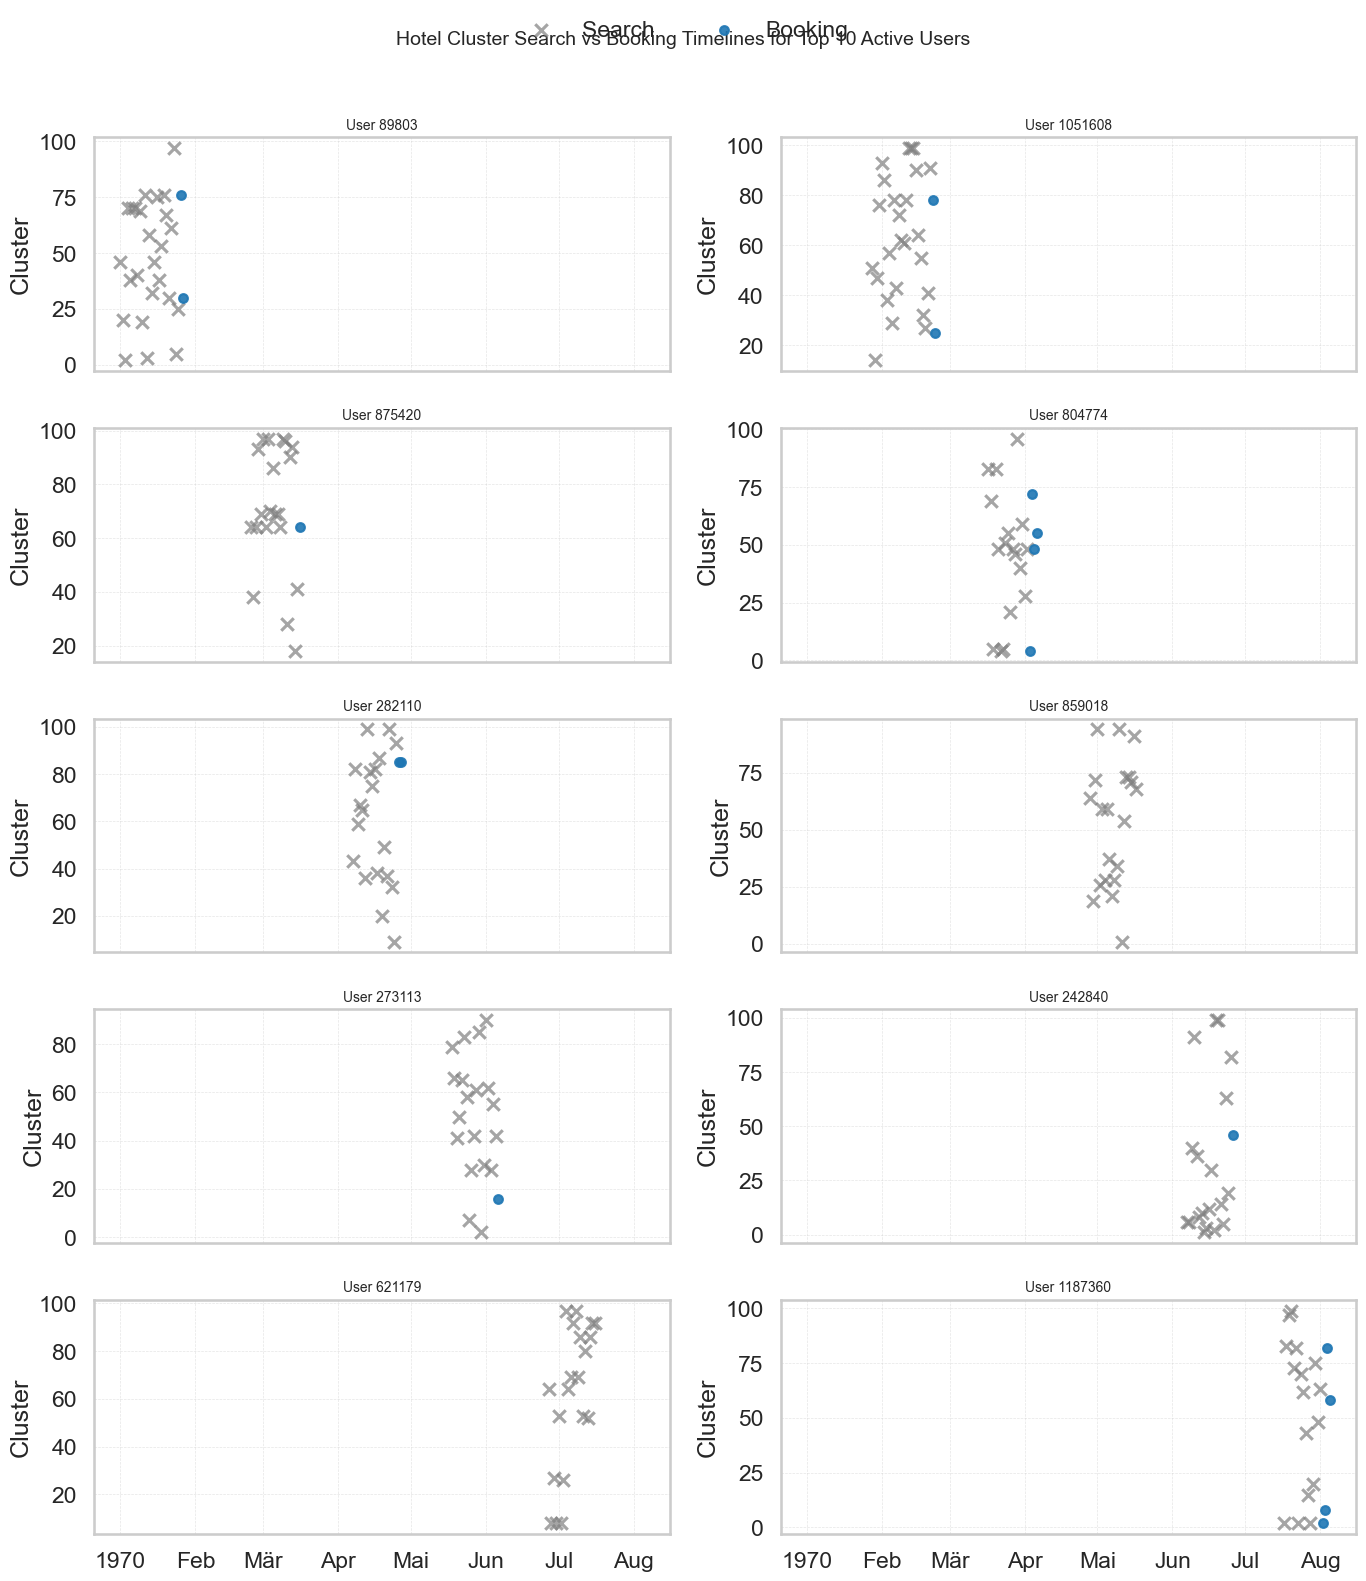

In [73]:
# Timeline comparison for the 10 most active users
import numpy as np
from pathlib import Path

# Determine top 10 users by number of events
top_users = df["user_id"].value_counts().head(10).index

# Prepare plot
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 16), sharex=True)
axes = axes.flatten()

# Colors: cycle for search/bookings to keep them distinct
colors = {
    "Search": "tab:gray",
    "Booking": "tab:blue"
}

for ax, user_id in zip(axes, top_users):
    df_user = df.loc[df["user_id"] == user_id, 
                     ["date_time", "hotel_cluster", "is_booking"]].sort_values("date_time")
    df_user["event_type"] = df_user["is_booking"].map({0: "Search", 1: "Booking"})
    
    # Scatter: searches and bookings
    ax.scatter(df_user.loc[df_user["is_booking"]==0, "date_time"],
               df_user.loc[df_user["is_booking"]==0, "hotel_cluster"],
               marker="x", alpha=0.7, label="Search", color=colors["Search"])
    ax.scatter(df_user.loc[df_user["is_booking"]==1, "date_time"],
               df_user.loc[df_user["is_booking"]==1, "hotel_cluster"],
               marker="o", s=40, alpha=0.9, label="Booking", color=colors["Booking"])
    
    # Formatting
    ax.set_title(f"User {user_id}", fontsize=10)
    ax.set_ylabel("Cluster")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    
# Improve date formatting for x-axis
locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
for ax in axes:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

# Hide unused subplots if any
for j in range(len(top_users), len(axes)):
    fig.delaxes(axes[j])

# Global labels and legend
fig.suptitle("Hotel Cluster Search vs Booking Timelines for Top 10 Active Users", fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.97])


These plots are showing some insights on user behaviour of the top 10 most heavy users related to the hotel clusters they were recommended. 